In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scipy

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Load data from directories
scalar_dir = "results_scalar"  # Directory containing scalar CSV files
vector_dir = "results_vector/results_vector_32"  # Directory containing vector CSV file

## Scalar CSV 
#### Creation of csv file of all perf's results for scalar executables

In [27]:
%

Makefile                 analysis_output_stride1/ scalar_pipeline.sh*
README.md                jupiter/                 src/
Untitled.ipynb           matrices/                stride_comparison.png
__pycache__/             mlir_files/              stride_grouped_analysis/
all_results_scalar.csv   python/                  vector_pipeline.sh*
all_results_vector/      results_scalar/
analysis_output/         results_vector/


In [54]:

# Directory containing the CSV files SCALAR
directory = scalar_dir  # Change this to your actual directory

# List to hold data from all files
dataframes = []

# Read all CSV files in the directory
# Read all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Standardize columns
        df.columns = ['Value', 'Unit', 'Metric', 'Percentage', 'Count', 'Total', 'Rate', 'Description']
        df.replace('', pd.NA, inplace=True)
        df.dropna(subset=['Value'], inplace=True)
        df['Value'] = pd.to_numeric(df['Value'])
        df['Rate'] = pd.to_numeric(df['Rate'])
        
        # Add dummy index for pivoting
        df['DummyIndex'] = range(len(df))
        
        # Pivot DataFrame
        df_pivot = df.pivot(index='DummyIndex', columns='Metric', values='Value')
        df_pivot = df_pivot.reset_index(drop=True)
        df_pivot.columns.name = None
        
        # Rename metrics for clarity
        translation_dict = {
            'task-clock': 'Task Clock',
            'context-switches': 'Context Switch',
            'cpu-migrations': 'CPU Migration',
            'page-faults': 'Page Faults',
            'cycles': 'Cycles',
            'instructions': 'Instructions',
            'branches': 'Branches',
            'branch-misses': 'Branch Misses'
        }
        df_pivot.rename(columns=translation_dict, inplace=True)
        
        # Extract sparsity and stride from filename
        match = re.search(r"sparsity_(\d+)_stride_(\d+)", filename)
        if match:
            sparsity = int(match.group(1))
            stride = int(match.group(2))
        else:
            sparsity = None
            stride = None
        
        # Add extracted data to DataFrame
        df_pivot['Executable'] = os.path.splitext(filename)[0]
        df_pivot['Sparsity Level'] = sparsity
        df_pivot['Stride'] = stride
        
        dataframes.append(df_pivot)
# Merge all DataFrames into one
final_df = pd.concat(dataframes, ignore_index=True)
# Sort the DataFrame by the 'Executable' column in alphabetical order
final_df_sorted = final_df.sort_values(by='Executable')

# If you want to sort in descending order (Z to A), add the ascending=False parameter
# final_df_sorted = final_df.sort_values(by='Executable', ascending=False)

# Reset the index if you want a fresh index after sorting
final_df_sorted = final_df_sorted.reset_index(drop=True)
name_csv=f"all_{directory}.csv"
final_df_sorted.to_csv(name_csv)
# Display the sorted DataFrame
final_df_sorted

,Branch Misses,Branches,Context Switch,CPU Migration,Cycles,Instructions,Page Faults,Executable,Sparsity Level,Stride
0,13742.0,NaN,NaN,NaN,NaN,NaN,NaN,mlir_sparsity_50_stride_1,50,1
1,NaN,620989.0,NaN,NaN,NaN,NaN,NaN,mlir_sparsity_50_stride_1,50,1
2,NaN,NaN,NaN,NaN,NaN,6499674.0,NaN,mlir_sparsity_50_stride_1,50,1
3,NaN,NaN,NaN,NaN,10100090.0,NaN,NaN,mlir_sparsity_50_stride_1,50,1
4,NaN,NaN,NaN,NaN,NaN,NaN,83.0,mlir_sparsity_50_stride_1,50,1
...,...,...,...,...,...,...,...,...,...,...
219,NaN,NaN,NaN,NaN,4255483.0,NaN,NaN,mlir_sparsity_95_stride_4,95,4
220,NaN,NaN,NaN,NaN,NaN,1455020.0,NaN,mlir_sparsity_95_stride_4,95,4
221,NaN,159081.0,NaN,NaN,NaN,NaN,NaN,mlir_sparsity_95_stride_4,95,4
222,13485.0,NaN,NaN,NaN,NaN,NaN,NaN,mlir_sparsity_95_stride_4,95,4


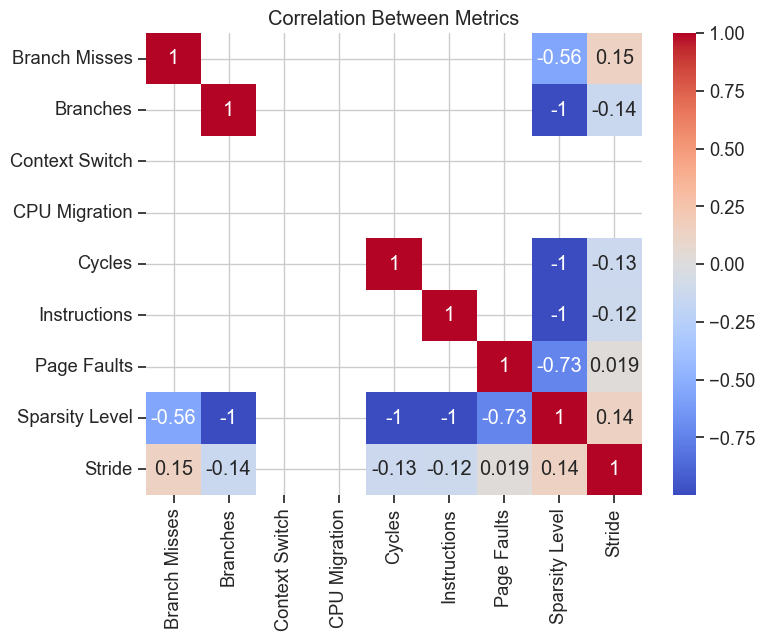

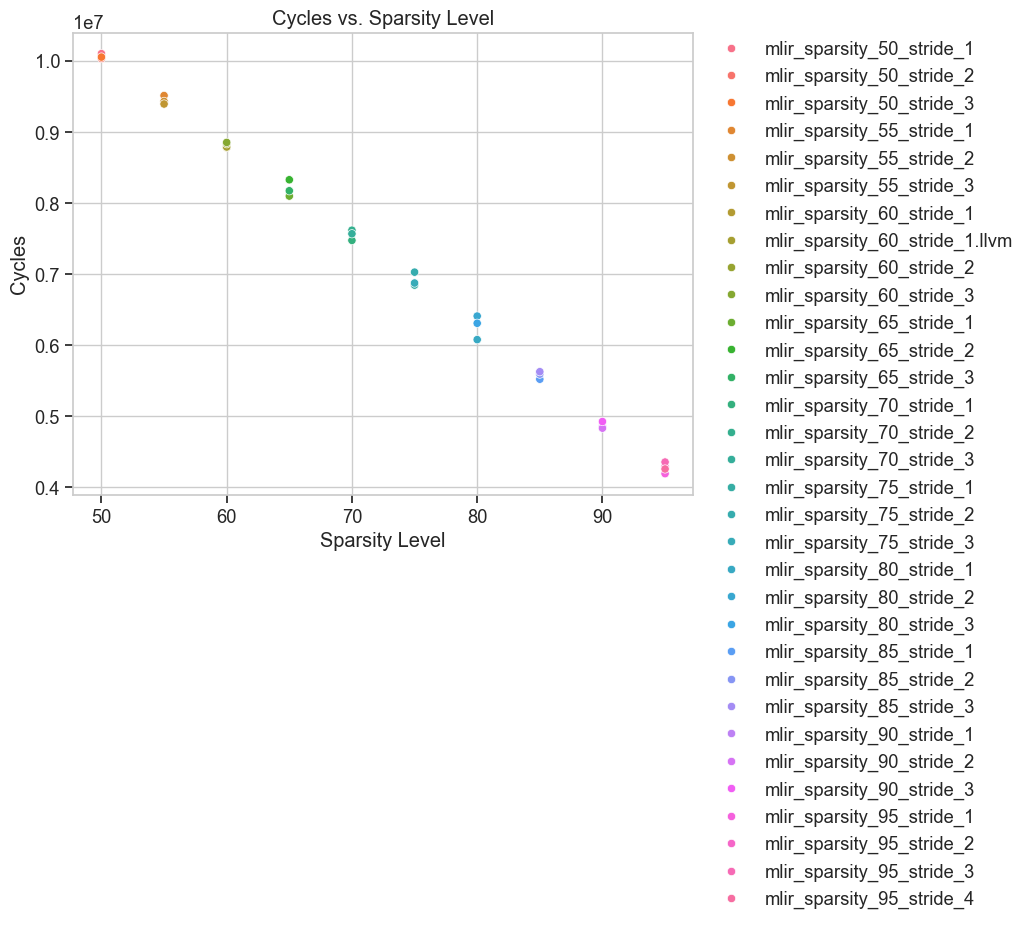

In [55]:

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(final_df_sorted.drop(columns=['Executable']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Metrics")
plt.show()

# Cycles vs Sparsity Level
if 'Sparsity Level' in final_df_sorted.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Sparsity Level', y='Cycles', hue='Executable', data=final_df_sorted)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title("Cycles vs. Sparsity Level")
    plt.show()



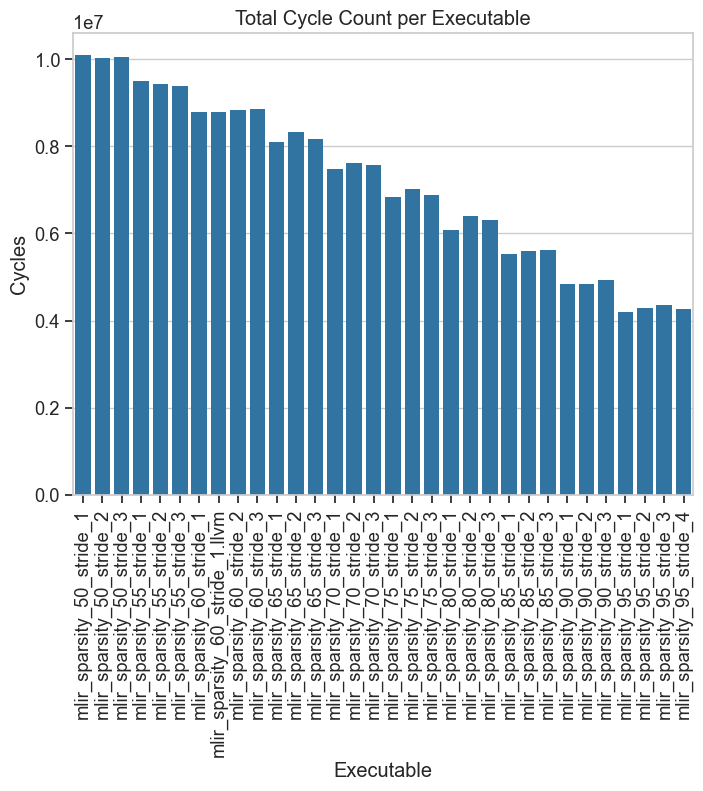

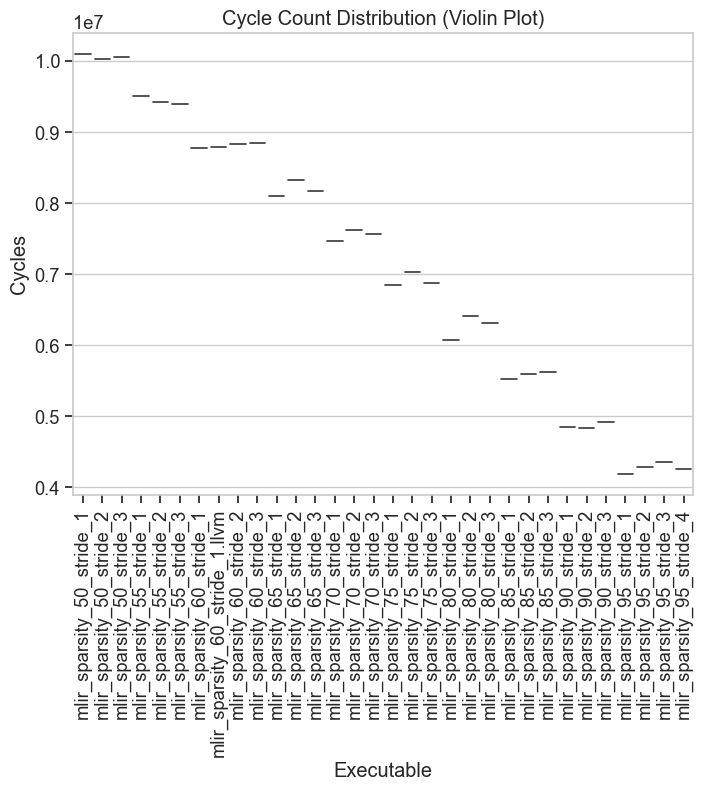

In [56]:
final_df_grouped = final_df.groupby('Executable')['Cycles'].sum().reset_index()

# Bar plot for grouped cycle count
plt.figure(figsize=(8, 6))
sns.barplot(x='Executable', y='Cycles', data=final_df_grouped)
plt.xticks(rotation=90)
plt.title("Total Cycle Count per Executable")
plt.show()

# Violin plot for cycle count distribution
plt.figure(figsize=(8, 6))
sns.violinplot(x='Executable', y='Cycles', data=final_df_sorted)
plt.xticks(rotation=90)
plt.title("Cycle Count Distribution (Violin Plot)")
plt.show()


## Vector CSV 
#### Creation of csv file of all perf's results for vectorized executables

In [30]:

# Directory containing the CSV files VECTOR
directory = vector_dir  # Change this to your actual directory

# List to hold data from all files
dataframes = []

# Read all CSV files in the directory
# Read all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Standardize columns
        df.columns = ['Value', 'Unit', 'Metric', 'Percentage', 'Count', 'Total', 'Rate', 'Description']
        df.replace('', pd.NA, inplace=True)
        df.dropna(subset=['Value'], inplace=True)
        df['Value'] = pd.to_numeric(df['Value'])
        df['Rate'] = pd.to_numeric(df['Rate'])
        
        # Add dummy index for pivoting
        df['DummyIndex'] = range(len(df))
        
        # Pivot DataFrame
        df_pivot = df.pivot(index='DummyIndex', columns='Metric', values='Value')
        df_pivot = df_pivot.reset_index(drop=True)
        df_pivot.columns.name = None
        
        # Rename metrics for clarity
        translation_dict = {
            'task-clock': 'Task Clock',
            'context-switches': 'Context Switch',
            'cpu-migrations': 'CPU Migration',
            'page-faults': 'Page Faults',
            'cycles': 'Cycles',
            'instructions': 'Instructions',
            'branches': 'Branches',
            'branch-misses': 'Branch Misses'
        }
        df_pivot.rename(columns=translation_dict, inplace=True)
        
        # Extract sparsity and stride from filename
        match = re.search(r"sparsity_(\d+)_stride_(\d+)", filename)
        if match:
            sparsity = int(match.group(1))
            stride = int(match.group(2))
        else:
            sparsity = None
            stride = None
        
        # Add extracted data to DataFrame
        df_pivot['Executable'] = os.path.splitext(filename)[0]
        df_pivot['Sparsity Level'] = sparsity
        df_pivot['Stride'] = stride
        
        dataframes.append(df_pivot)
# Merge all DataFrames into one
final_df = pd.concat(dataframes, ignore_index=True)
# Sort the DataFrame by the 'Executable' column in alphabetical order
final_df_sorted = final_df.sort_values(by='Executable')

# If you want to sort in descending order (Z to A), add the ascending=False parameter
# final_df_sorted = final_df.sort_values(by='Executable', ascending=False)

# Reset the index if you want a fresh index after sorting
final_df_sorted = final_df_sorted.reset_index(drop=True)
name_csv=f"all_{directory}.csv"
final_df_sorted.to_csv(name_csv)
# Display the sorted DataFrame
final_df_sorted

,Branch Misses,Branches,Context Switch,CPU Migration,Cycles,Instructions,Page Faults,Executable,Sparsity Level,Stride
0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,results_vector_mlir_sparsity_50_stride_1,50,1
1,NaN,NaN,NaN,NaN,NaN,NaN,82.0,results_vector_mlir_sparsity_50_stride_1,50,1
2,NaN,NaN,NaN,NaN,13156555.0,NaN,NaN,results_vector_mlir_sparsity_50_stride_1,50,1
3,NaN,NaN,NaN,NaN,NaN,2137281.0,NaN,results_vector_mlir_sparsity_50_stride_1,50,1
4,NaN,130601.0,NaN,NaN,NaN,NaN,NaN,results_vector_mlir_sparsity_50_stride_1,50,1
...,...,...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,1007568.0,NaN,results_vector_mlir_sparsity_95_stride_4,95,4
213,NaN,108584.0,NaN,NaN,NaN,NaN,NaN,results_vector_mlir_sparsity_95_stride_4,95,4
214,13476.0,NaN,NaN,NaN,NaN,NaN,NaN,results_vector_mlir_sparsity_95_stride_4,95,4
215,NaN,NaN,0.0,NaN,NaN,NaN,NaN,results_vector_mlir_sparsity_95_stride_4,95,4


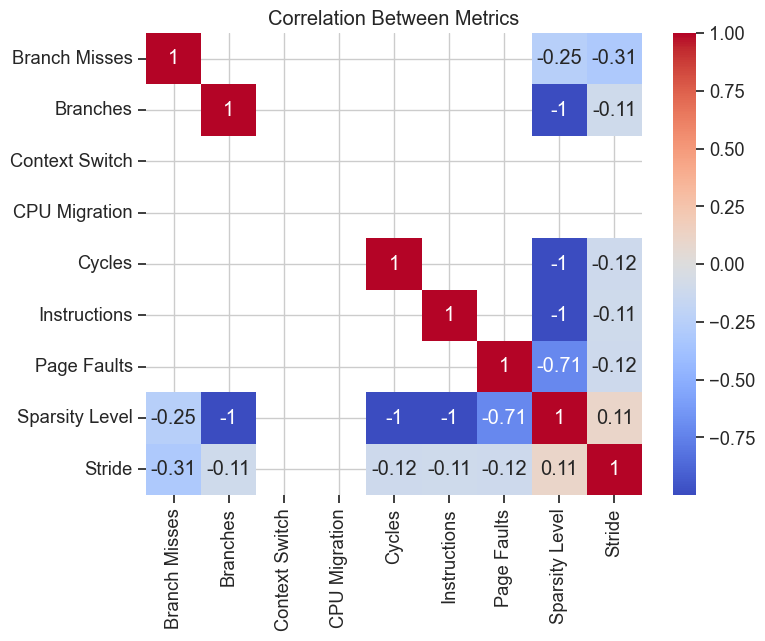

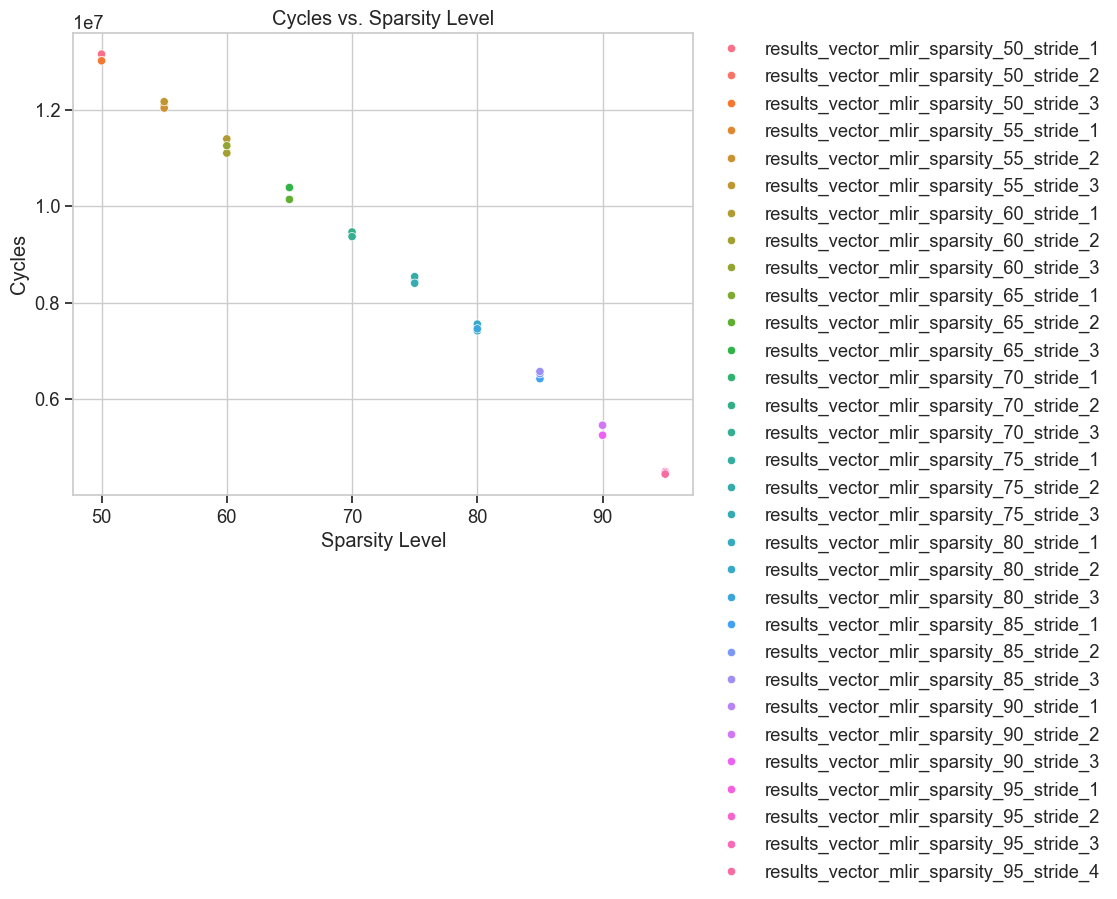

In [31]:

# Visualization

plt.figure(figsize=(8, 6))
sns.heatmap(final_df_sorted.drop(columns=['Executable']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Metrics")
plt.show()

# Cycles vs Sparsity Level
if 'Sparsity Level' in final_df_sorted.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Sparsity Level', y='Cycles', hue='Executable', data=final_df_sorted)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.title("Cycles vs. Sparsity Level")
    plt.show()


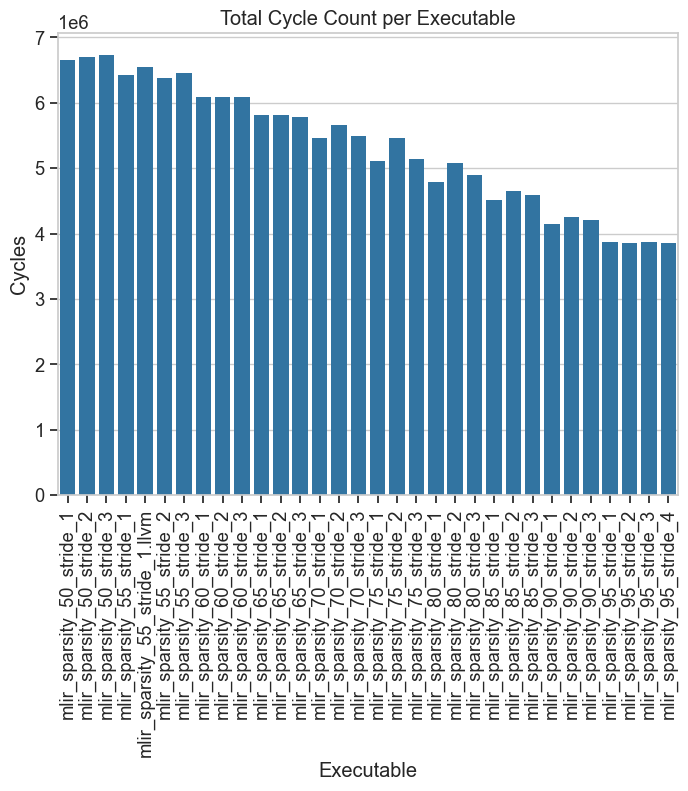

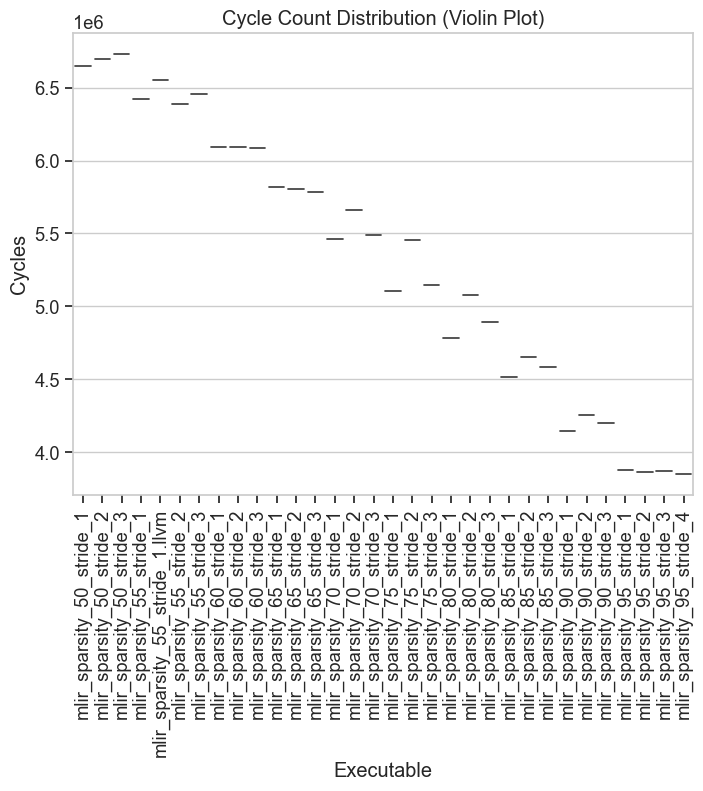

In [59]:
final_df_grouped = final_df.groupby('Executable')['Cycles'].sum().reset_index()

# Bar plot for grouped cycle count
plt.figure(figsize=(8, 6))
sns.barplot(x='Executable', y='Cycles', data=final_df_grouped)
plt.xticks(rotation=90)
plt.title("Total Cycle Count per Executable")
plt.show()

# Violin plot for cycle count distribution
plt.figure(figsize=(8, 6))
sns.violinplot(x='Executable', y='Cycles', data=final_df_sorted)
plt.xticks(rotation=90)
plt.title("Cycle Count Distribution (Violin Plot)")
plt.show()



Loading and processing data...
Calculating speedup metrics...
Performing statistical analysis...
Generating plots...

Summary of Analysis:
1. Average cycles speedup (scalar/vector): 1.33x
2. Average instructions speedup: 2.81x
3. Average cycles - Vector: 5327291.62, Scalar: 7155183.62
4. Best cycles speedup: 1.52x at Sparsity=50.0%, Stride=1.0
5. Worst cycles speedup: 1.08x at Sparsity=95.0%, Stride=1.0
6. High sparsity (>=80%) - Vector: 4351824.08, Scalar: 5170261.85, Ratio: 1.19x
7. Low sparsity (<=60%) - Vector: 6416339.90, Scalar: 9376589.70, Ratio: 1.46x
8. High stride (>=4) - Vector: 3850411.00, Scalar: 4255483.00, Ratio: 1.11x
9. Low stride (<=2) - Vector: 5398549.76, Scalar: 7266682.24, Ratio: 1.35x

Analysis complete. All results saved to the 'analysis_output' directory.


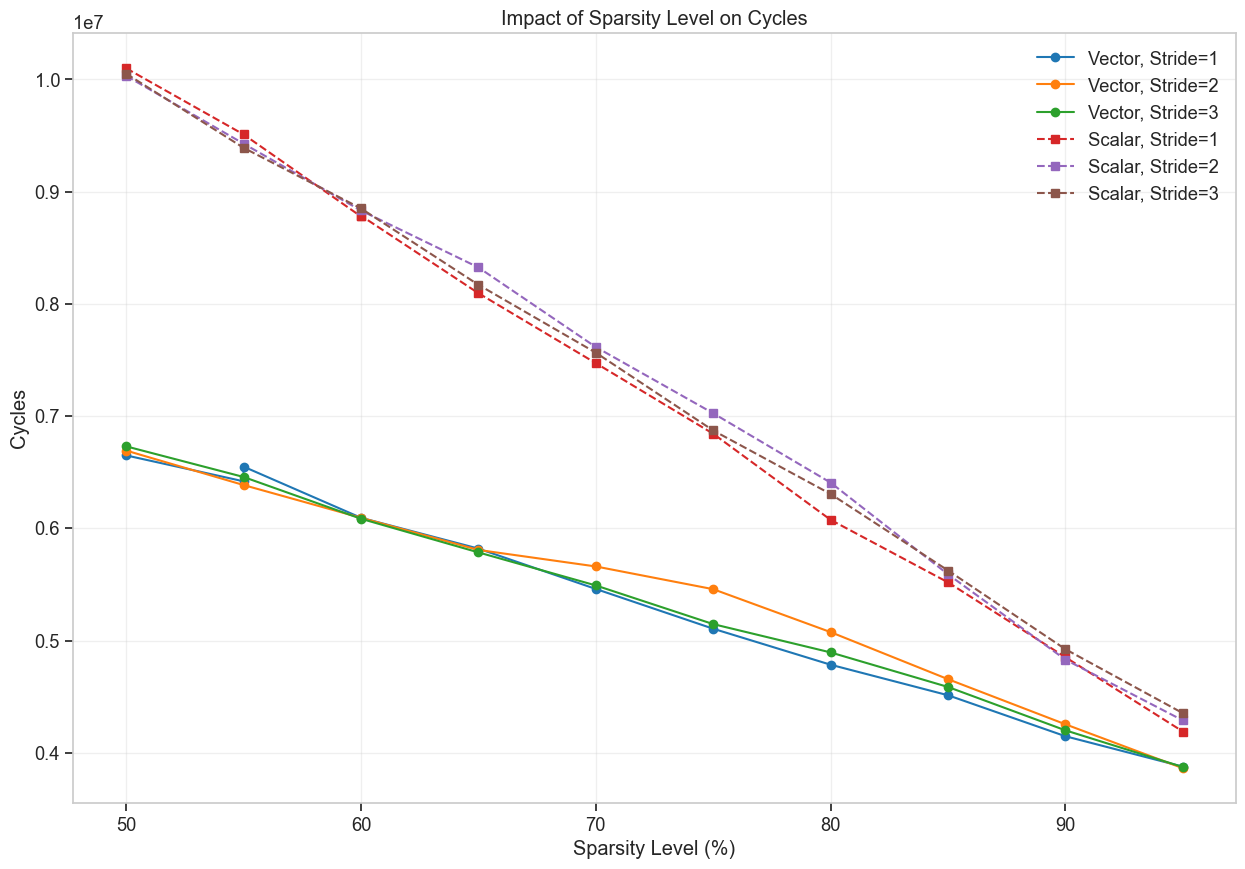

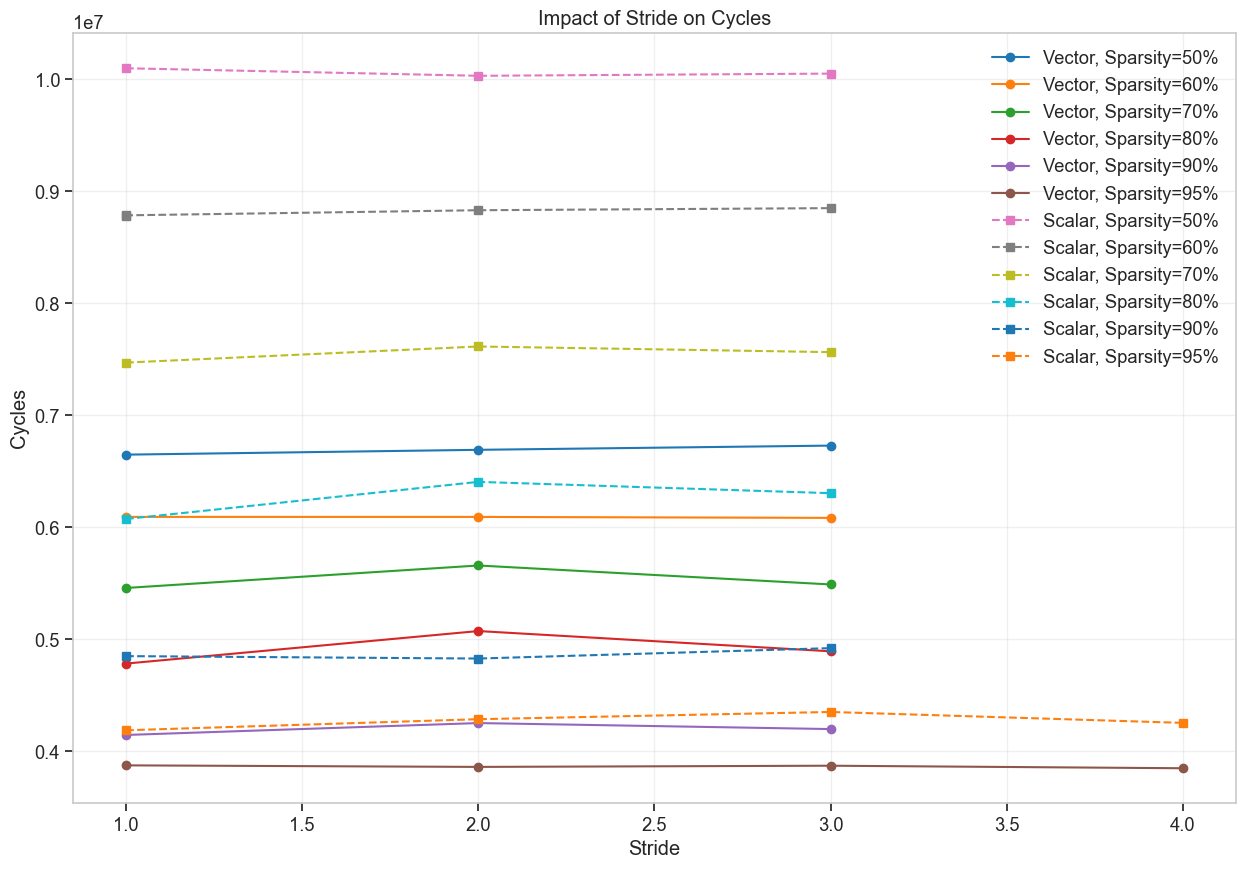

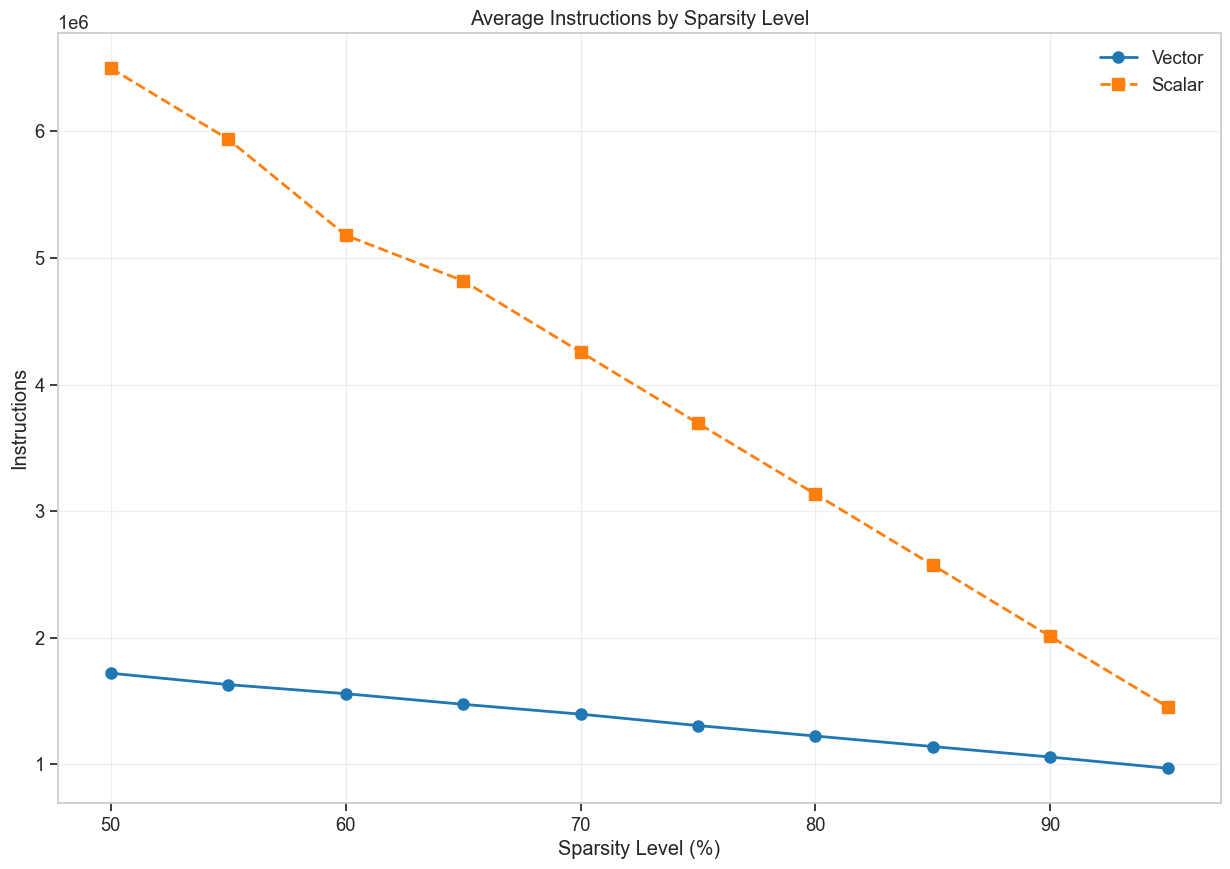

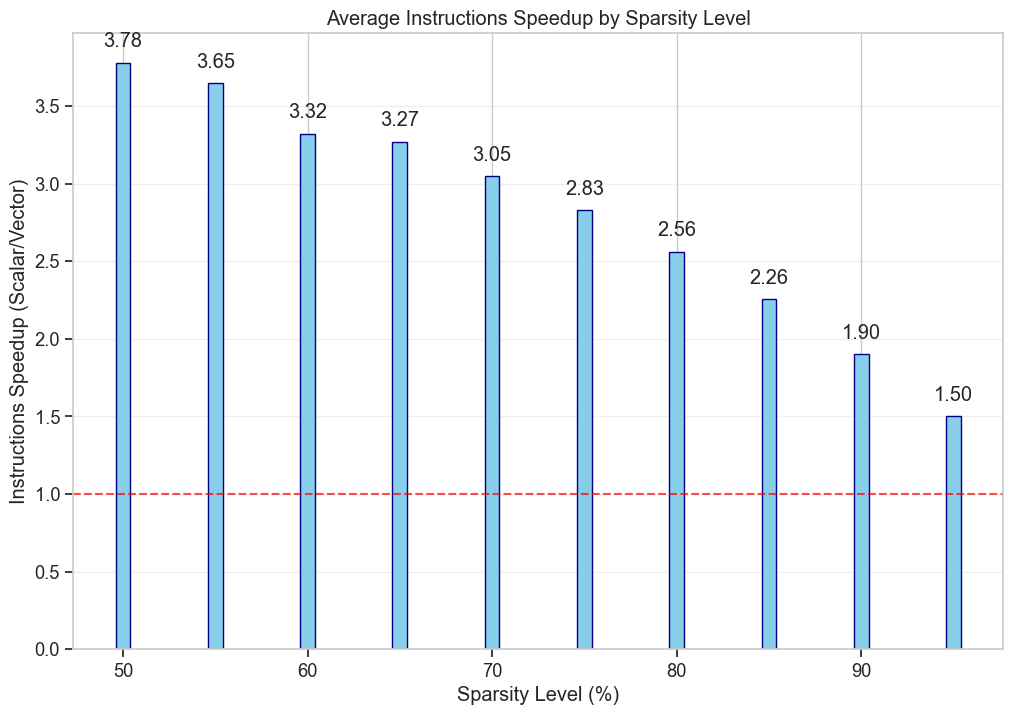

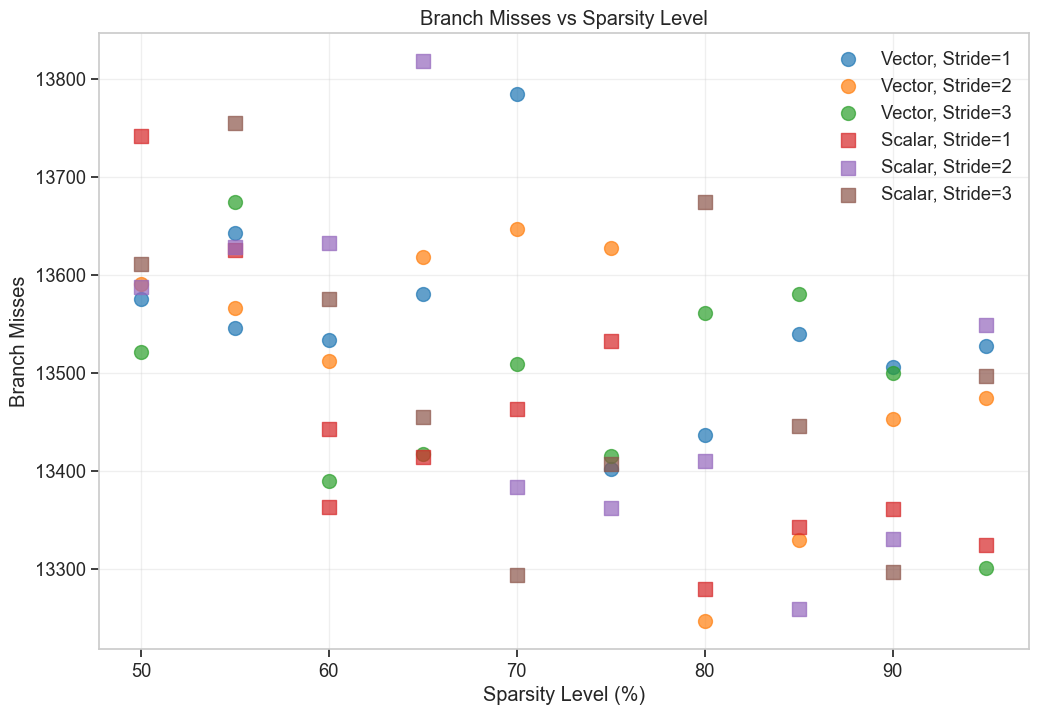

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define the data processing functions
def load_and_process_data(vector_file, scalar_file):
    """
    Load and process the vector and scalar data from CSV files.
    
    Parameters:
    vector_file (str): Path to the vector CSV file
    scalar_file (str): Path to the scalar CSV file
    
    Returns:
    tuple: (vector_df, scalar_df, combined_df)
    """
    # Load the CSV files
    vector_raw = pd.read_csv(vector_file)
    scalar_raw = pd.read_csv(scalar_file)
    
    # Add a column to identify the source
    vector_raw['Implementation'] = 'Vector'
    scalar_raw['Implementation'] = 'Scalar'
    
    # The data is stored in a sparse format where each row has only one metric value
    # Let's reshape it to have one row per experiment
    
    def reshape_df(df):
        # Initialize dictionary to store results
        results = {}
        
        # Extract unique combinations of Executable, Sparsity Level, and Stride
        unique_exps = df[['Executable', 'Sparsity Level', 'Stride']].drop_duplicates()
        
        # For each unique experiment
        for _, exp in unique_exps.iterrows():
            exe = exp['Executable']
            sparsity = exp['Sparsity Level']
            stride = exp['Stride']
            
            # Create a key for this experiment
            key = (exe, sparsity, stride)
            results[key] = {'Executable': exe, 
                           'Sparsity Level': sparsity, 
                           'Stride': stride,
                           'Implementation': df['Implementation'].iloc[0]}
            
            # Find all rows for this experiment
            mask = ((df['Executable'] == exe) & 
                   (df['Sparsity Level'] == sparsity) & 
                   (df['Stride'] == stride))
            
            # For each metric, find the corresponding value
            for metric in ['Branch Misses', 'Branches', 'Context Switch', 'CPU Migration', 
                          'Cycles', 'Instructions', 'Page Faults']:
                metric_row = df[mask & ~df[metric].isna()]
                if len(metric_row) > 0:
                    results[key][f'{metric}_value'] = metric_row[metric].iloc[0]
        
        # Convert results to DataFrame
        return pd.DataFrame(list(results.values()))
    
    # Reshape both dataframes
    vector_df = reshape_df(vector_raw)
    scalar_df = reshape_df(scalar_raw)
    
    # Combine them
    combined_df = pd.concat([vector_df, scalar_df], ignore_index=True)
    
    return vector_df, scalar_df, combined_df

def calculate_speedup(vector_df, scalar_df):
    """
    Calculate speedup of vector implementation over scalar.
    
    Parameters:
    vector_df (DataFrame): Vector processed dataframe
    scalar_df (DataFrame): Scalar processed dataframe
    
    Returns:
    DataFrame: Speedup metrics
    """
    # Merge on Sparsity Level and Stride
    merged = pd.merge(vector_df, scalar_df, 
                     on=['Sparsity Level', 'Stride'],
                     suffixes=('_vector', '_scalar'))
    
    # Calculate speedup metrics
    merged['cycles_speedup'] = merged['Cycles_value_scalar'] / merged['Cycles_value_vector']
    merged['instructions_speedup'] = merged['Instructions_value_scalar'] / merged['Instructions_value_vector']
    merged['branches_speedup'] = merged['Branches_value_scalar'] / merged['Branches_value_vector']
    
    return merged[['Sparsity Level', 'Stride', 'cycles_speedup', 
                  'instructions_speedup', 'branches_speedup']]

def perform_statistical_analysis(combined_df):
    """
    Perform statistical analysis to determine significance of relationships.
    """
    results = {}
    
    # For vector implementation
    vector_data = combined_df[combined_df['Implementation'] == 'Vector']
    
    # Correlation between sparsity and cycles for vector
    corr_sparsity_cycles_v = stats.pearsonr(
        vector_data['Sparsity Level'], vector_data['Cycles_value'])
    results['Vector Sparsity-Cycles Correlation'] = {
        'r': corr_sparsity_cycles_v[0],
        'p-value': corr_sparsity_cycles_v[1]
    }
    
    # Correlation between stride and cycles for vector
    corr_stride_cycles_v = stats.pearsonr(
        vector_data['Stride'], vector_data['Cycles_value'])
    results['Vector Stride-Cycles Correlation'] = {
        'r': corr_stride_cycles_v[0],
        'p-value': corr_stride_cycles_v[1]
    }
    
    # For scalar implementation
    scalar_data = combined_df[combined_df['Implementation'] == 'Scalar']
    
    # Correlation between sparsity and cycles for scalar
    corr_sparsity_cycles_s = stats.pearsonr(
        scalar_data['Sparsity Level'], scalar_data['Cycles_value'])
    results['Scalar Sparsity-Cycles Correlation'] = {
        'r': corr_sparsity_cycles_s[0],
        'p-value': corr_sparsity_cycles_s[1]
    }
    
    # Correlation between stride and cycles for scalar
    corr_stride_cycles_s = stats.pearsonr(
        scalar_data['Stride'], scalar_data['Cycles_value'])
    results['Scalar Stride-Cycles Correlation'] = {
        'r': corr_stride_cycles_s[0],
        'p-value': corr_stride_cycles_s[1]
    }
    
    # T-test comparing cycles between vector and scalar implementations
    vector_cycles = vector_data['Cycles_value']
    scalar_cycles = scalar_data['Cycles_value']
    ttest_result = stats.ttest_ind(vector_cycles, scalar_cycles)
    results['Vector vs Scalar Cycles T-test'] = {
        't-statistic': ttest_result[0],
        'p-value': ttest_result[1]
    }
    
    return results

def main():
    """
    Main function to execute the analysis.
    """
    # File paths - update these with your actual file paths
    vector_file = 'all_results_vector.csv'
    scalar_file = 'all_results_scalar.csv'
    
    # Create output directory for plots if it doesn't exist
    output_dir = 'analysis_output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Load and process data
    print("Loading and processing data...")
    vector_df, scalar_df, combined_df = load_and_process_data(vector_file, scalar_file)
    
    # Calculate speedup
    print("Calculating speedup metrics...")
    speedup_df = calculate_speedup(vector_df, scalar_df)
    
    # Perform statistical analysis
    print("Performing statistical analysis...")
    stats_results = perform_statistical_analysis(combined_df)
    
    # Generate plots
    print("Generating plots...")
    
    # Plot 1: Sparsity Impact
    plt.figure(figsize=(15, 10))
    for implementation in ['Vector', 'Scalar']:
        for stride in [1, 2,3]:
            subset = combined_df[(combined_df['Implementation'] == implementation) & 
                                (combined_df['Stride'] == stride)]
            plt.plot(subset['Sparsity Level'], subset['Cycles_value'], 
                    marker='o' if implementation == 'Vector' else 's',
                    linestyle='-' if implementation == 'Vector' else '--',
                    label=f"{implementation}, Stride={stride}")
    
    plt.title('Impact of Sparsity Level on Cycles')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Cycles')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/sparsity_impact_on_cycles.png", dpi=300, bbox_inches='tight')
    
    # Plot 2: Stride Impact
    plt.figure(figsize=(15, 10))
    for implementation in ['Vector', 'Scalar']:
        for sparsity in [50, 60, 70, 80, 90,95]:
            subset = combined_df[(combined_df['Implementation'] == implementation) & 
                                (combined_df['Sparsity Level'] == sparsity)]
            plt.plot(subset['Stride'], subset['Cycles_value'], 
                    marker='o' if implementation == 'Vector' else 's',
                    linestyle='-' if implementation == 'Vector' else '--',
                    label=f"{implementation}, Sparsity={sparsity}%")
    
    plt.title('Impact of Stride on Cycles')
    plt.xlabel('Stride')
    plt.ylabel('Cycles')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/stride_impact_on_cycles.png", dpi=300, bbox_inches='tight')
    
    # Plot 4: Instructions Comparison
    plt.figure(figsize=(15, 10))
    for implementation in ['Vector', 'Scalar']:
        grouped = combined_df[combined_df['Implementation'] == implementation].groupby('Sparsity Level')['Instructions_value'].mean()
        plt.plot(grouped.index, grouped.values, 
                marker='o' if implementation == 'Vector' else 's',
                linestyle='-' if implementation == 'Vector' else '--',
                linewidth=2, markersize=8,
                label=f"{implementation}")
    
    plt.title('Average Instructions by Sparsity Level')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Instructions')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/avg_instructions_by_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Plot 5: Instructions Speedup by Sparsity Level
    plt.figure(figsize=(12, 8))
    avg_speedup = speedup_df.groupby('Sparsity Level')['instructions_speedup'].mean()
    plt.bar(avg_speedup.index, avg_speedup.values, color='skyblue', edgecolor='navy')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
    plt.title('Average Instructions Speedup by Sparsity Level')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Instructions Speedup (Scalar/Vector)')
    plt.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(avg_speedup.values):
        plt.text(avg_speedup.index[i], v + 0.1, f"{v:.2f}", ha='center')
    
    plt.savefig(f"{output_dir}/avg_instructions_speedup_by_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Plot 6: Combined analysis of branch misses
    plt.figure(figsize=(12, 8))
    for implementation in ['Vector', 'Scalar']:
        for stride in [1, 2, 3]:
            subset = combined_df[(combined_df['Implementation'] == implementation) & 
                                (combined_df['Stride'] == stride)]
            plt.scatter(subset['Sparsity Level'], subset['Branch Misses_value'], 
                       s=100, alpha=0.7,
                       marker='o' if implementation == 'Vector' else 's',
                       label=f"{implementation}, Stride={stride}")
    
    plt.title('Branch Misses vs Sparsity Level')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Branch Misses')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/branch_misses_vs_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Save statistical analysis results
    with open(f"{output_dir}/statistical_analysis.txt", 'w') as f:
        f.write("Statistical Analysis Results\n")
        f.write("============================\n\n")
        for key, value in stats_results.items():
            f.write(f"{key}:\n")
            for stat_key, stat_value in value.items():
                f.write(f"  {stat_key}: {stat_value}\n")
            f.write("\n")
    
    # Print summary of findings
    print("\nSummary of Analysis:")
    print("===================")
    print(f"1. Average cycles speedup (scalar/vector): {speedup_df['cycles_speedup'].mean():.2f}x")
    print(f"2. Average instructions speedup: {speedup_df['instructions_speedup'].mean():.2f}x")
    
    # Vector vs Scalar overall comparison
    vector_cycles = combined_df[combined_df['Implementation'] == 'Vector']['Cycles_value'].mean()
    scalar_cycles = combined_df[combined_df['Implementation'] == 'Scalar']['Cycles_value'].mean()
    print(f"3. Average cycles - Vector: {vector_cycles:.2f}, Scalar: {scalar_cycles:.2f}")
    
    # Best speedup scenario
    best_speedup_idx = speedup_df['cycles_speedup'].idxmax()
    best_scenario = speedup_df.iloc[best_speedup_idx]
    print(f"4. Best cycles speedup: {best_scenario['cycles_speedup']:.2f}x at Sparsity={best_scenario['Sparsity Level']}%, Stride={best_scenario['Stride']}")
    
    # Worst speedup scenario
    worst_speedup_idx = speedup_df['cycles_speedup'].idxmin()
    worst_scenario = speedup_df.iloc[worst_speedup_idx]
    print(f"5. Worst cycles speedup: {worst_scenario['cycles_speedup']:.2f}x at Sparsity={worst_scenario['Sparsity Level']}%, Stride={worst_scenario['Stride']}")
    
    # Sparsity impact
    high_sparsity = combined_df[combined_df['Sparsity Level'] >= 80]
    low_sparsity = combined_df[combined_df['Sparsity Level'] <= 60]
    
    high_sparsity_vector = high_sparsity[high_sparsity['Implementation'] == 'Vector']['Cycles_value'].mean()
    high_sparsity_scalar = high_sparsity[high_sparsity['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    low_sparsity_vector = low_sparsity[low_sparsity['Implementation'] == 'Vector']['Cycles_value'].mean()
    low_sparsity_scalar = low_sparsity[low_sparsity['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    print(f"6. High sparsity (>=80%) - Vector: {high_sparsity_vector:.2f}, Scalar: {high_sparsity_scalar:.2f}, Ratio: {high_sparsity_scalar/high_sparsity_vector:.2f}x")
    print(f"7. Low sparsity (<=60%) - Vector: {low_sparsity_vector:.2f}, Scalar: {low_sparsity_scalar:.2f}, Ratio: {low_sparsity_scalar/low_sparsity_vector:.2f}x")
    
    # Stride impact
    high_stride = combined_df[combined_df['Stride'] >= 4]
    low_stride = combined_df[combined_df['Stride'] <= 2]
    
    high_stride_vector = high_stride[high_stride['Implementation'] == 'Vector']['Cycles_value'].mean()
    high_stride_scalar = high_stride[high_stride['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    low_stride_vector = low_stride[low_stride['Implementation'] == 'Vector']['Cycles_value'].mean()
    low_stride_scalar = low_stride[low_stride['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    print(f"8. High stride (>=4) - Vector: {high_stride_vector:.2f}, Scalar: {high_stride_scalar:.2f}, Ratio: {high_stride_scalar/high_stride_vector:.2f}x")
    print(f"9. Low stride (<=2) - Vector: {low_stride_vector:.2f}, Scalar: {low_stride_scalar:.2f}, Ratio: {low_stride_scalar/low_stride_vector:.2f}x")
    
    # Save all dataframes
    vector_df.to_csv(f"{output_dir}/processed_vector_data.csv", index=False)
    scalar_df.to_csv(f"{output_dir}/processed_scalar_data.csv", index=False)
    combined_df.to_csv(f"{output_dir}/combined_data.csv", index=False)
    speedup_df.to_csv(f"{output_dir}/speedup_metrics.csv", index=False)
    
    print("\nAnalysis complete. All results saved to the 'analysis_output' directory.")



main()

# NEW UPDATE

Aggregated Metrics:


,Sparsity Level,Stride,Cycles,Instructions,Branch Misses,Branches,IPC
0,50,1,10100090.0,6499674.0,13742.0,620989.0,0.643526
1,50,2,10032793.0,6500318.0,13588.0,620953.0,0.647907
2,50,3,10052251.0,6496454.0,13611.0,620548.0,0.646269
3,55,1,9510600.0,5944308.0,13626.0,570344.0,0.625019
4,55,2,9428167.0,5933093.0,13629.0,568754.0,0.629294


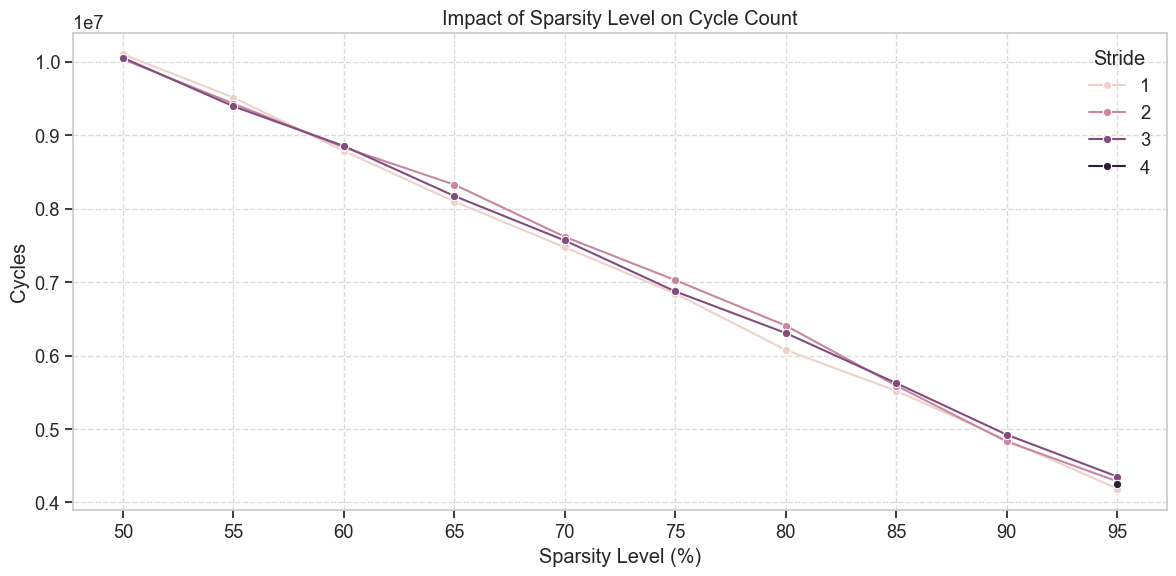

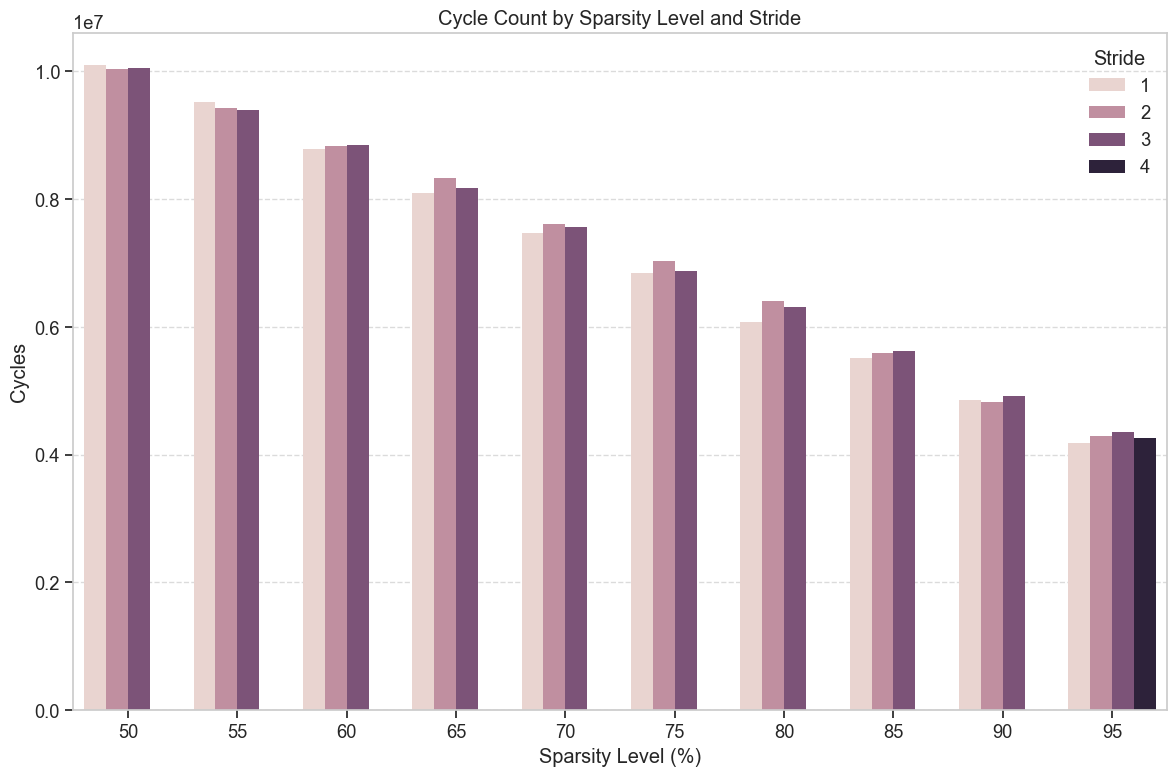

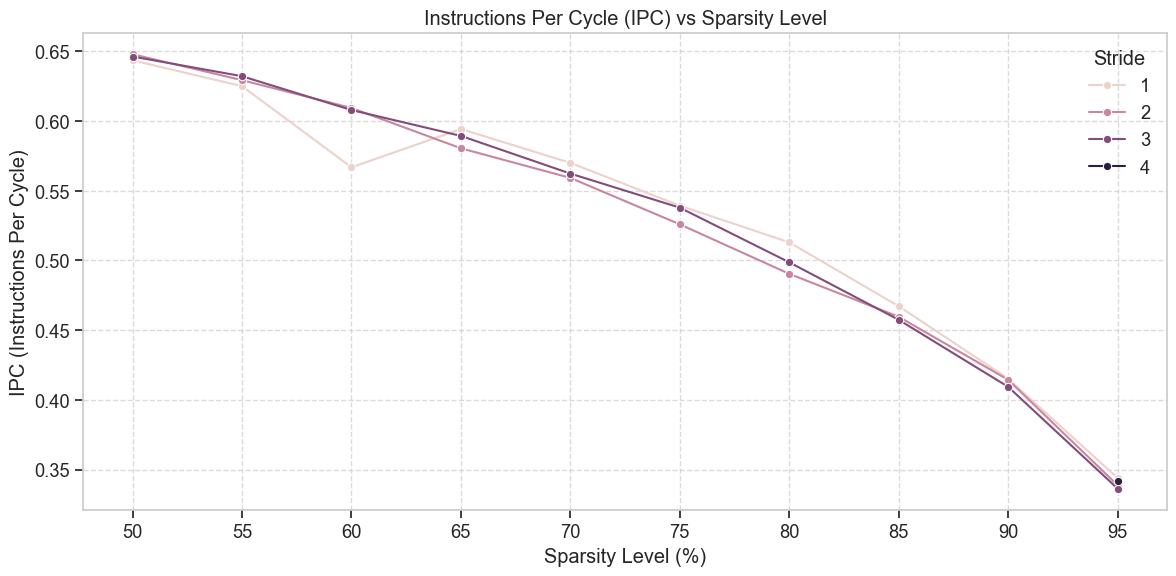

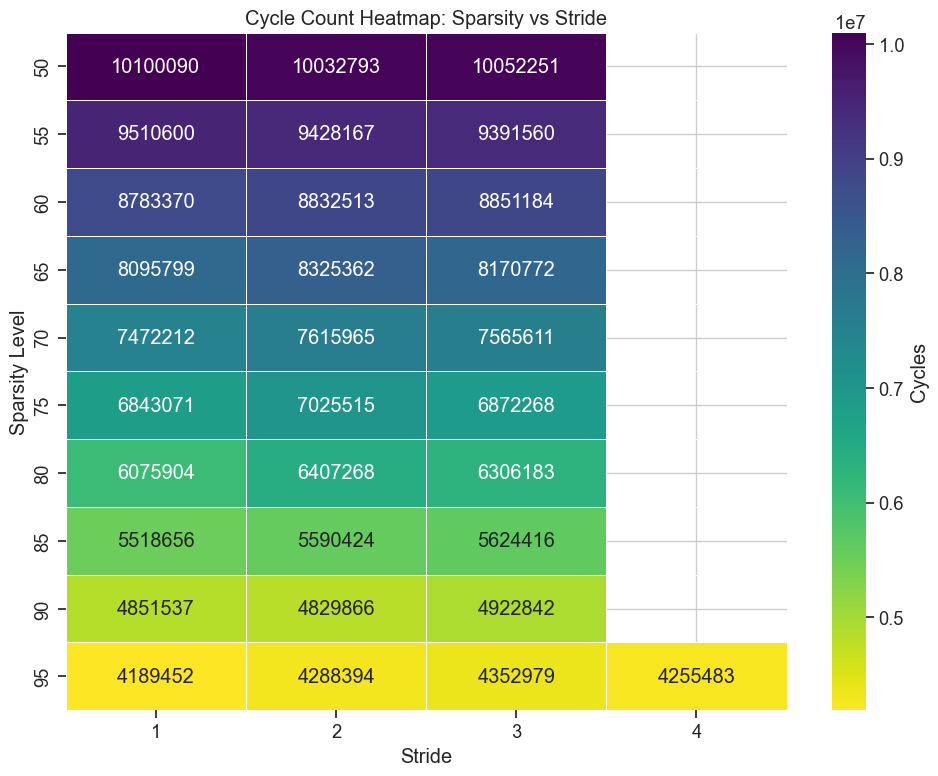

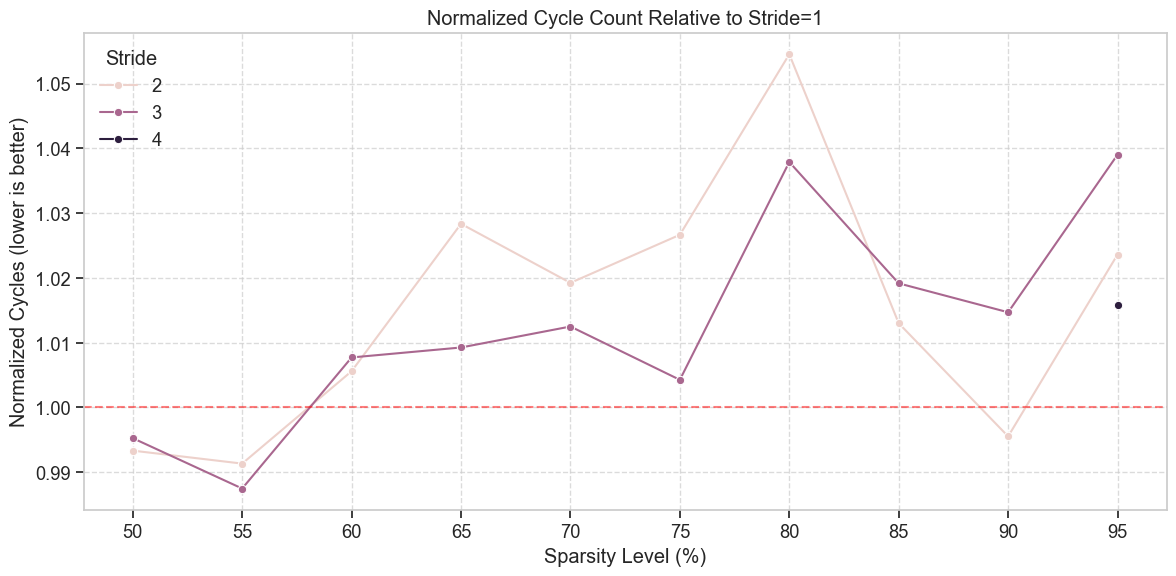

<Figure size 1200x600 with 0 Axes>

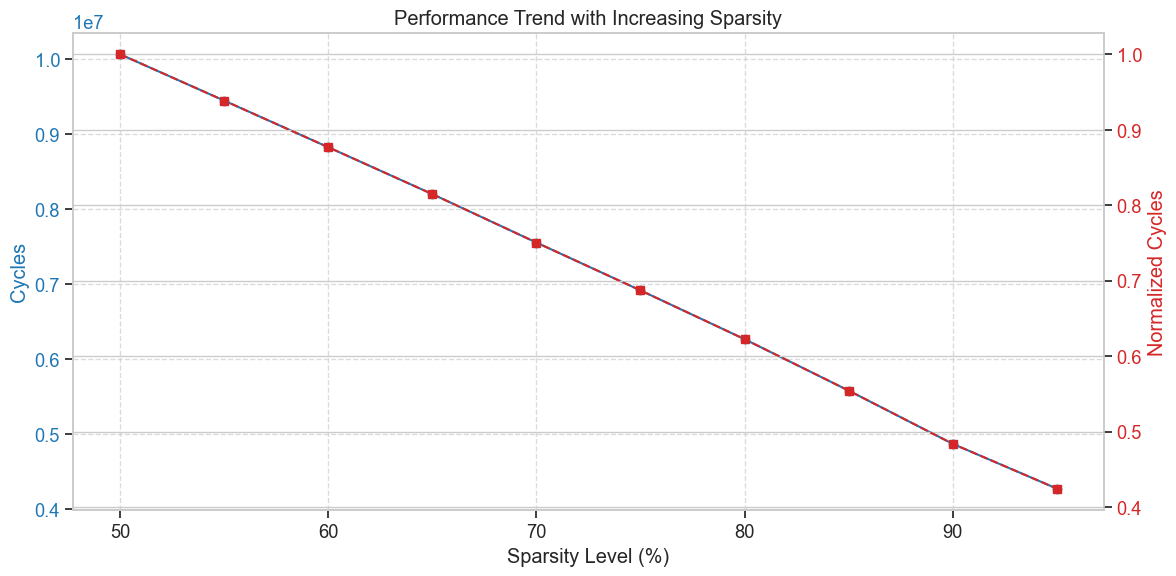


Summary Statistics by Sparsity Level:


Cycles                          Instructions       IPC
                        mean         min         max          mean      mean
Sparsity Level                                                              
50              1.006171e+07  10032793.0  10100090.0  6.498815e+06  0.645901
55              9.443442e+06   9391560.0   9510600.0  5.938074e+06  0.628819
60              8.822356e+06   8783369.5   8851184.0  5.246963e+06  0.594674
65              8.197311e+06   8095799.0   8325362.0  4.819529e+06  0.588007
70              7.551263e+06   7472212.0   7615965.0  4.257362e+06  0.563830
75              6.913618e+06   6843071.0   7025515.0  3.693802e+06  0.534348
80              6.263118e+06   6075904.0   6407268.0  3.134444e+06  0.500667
85              5.577832e+06   5518656.0   5624416.0  2.573372e+06  0.461390
90              4.868082e+06   4829866.0   4922842.0  2.010283e+06  0.412972
95              4.271577e+06   4189452.0   4352979.0  1.453282e+06  0.340261


Summary Statistics by Stride:


Cycles                        Instructions       IPC
              mean        min         max         mean      mean
Stride                                                          
1       7144069.05  4189452.0  10100090.0   3933300.05  0.527817
2       7237626.70  4288394.0  10032793.0   3976713.20  0.525524
3       7211006.60  4352979.0  10052251.0   3977590.90  0.527754
4       4255483.00  4255483.0   4255483.0   1455020.00  0.341917


Most Efficient Configurations (Highest IPC):


,Sparsity Level,Stride,Cycles,Instructions,Efficiency
1,50,2,10032793.0,6500318.0,0.647907
2,50,3,10052251.0,6496454.0,0.646269
0,50,1,10100090.0,6499674.0,0.643526
5,55,3,9391560.0,5936820.0,0.632144
4,55,2,9428167.0,5933093.0,0.629294



Least Efficient Configurations (Lowest IPC):


,Sparsity Level,Stride,Cycles,Instructions,Efficiency
29,95,3,4352979.0,1464181.0,0.336363
28,95,2,4288394.0,1452736.0,0.338760
30,95,4,4255483.0,1455020.0,0.341917
27,95,1,4189452.0,1441193.0,0.344005
26,90,3,4922842.0,2015196.0,0.409356



Conclusions:
1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count generally decreases by 57.5%
2. Impact of Stride: Compared to Stride=1:
   - Stride=2: 1.3% increase in cycles
   - Stride=3: 0.9% increase in cycles
   - Stride=4: -40.4% decrease in cycles
3. Best Configuration: Sparsity=95.0%, Stride=1.0, Cycles=4189452
4. Worst Configuration: Sparsity=50.0%, Stride=1.0, Cycles=10100090


In [63]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
# Assuming the CSV file is saved as 'sparsity_data.csv'
# If your data is already in this notebook, you can create the dataframe directly

# For this example, I'll create a dataframe from scratch based on your provided data
data_rows = []

# Add header names and types that match your data structure
column_names = ['index', 'Branch Misses', 'Branches', 'Context Switch', 'CPU Migration', 
                'Cycles', 'Instructions', 'Page Faults', 'Executable', 'Sparsity Level', 
                'Stride', 'Implementation']

# Parse the data and clean it up
with open('all_results_scalar.csv', 'r') as f:
    lines = f.readlines()
    
    for line in lines[1:]:  # Skip header
        parts = line.strip().split(',')
        row = {}
        
        # Convert to appropriate types
        row['index'] = int(parts[0]) if parts[0] else None
        row['Branch Misses'] = float(parts[1]) if parts[1] else None
        row['Branches'] = float(parts[2]) if parts[2] else None
        row['Context Switch'] = float(parts[3]) if parts[3] else None
        row['CPU Migration'] = float(parts[4]) if parts[4] else None
        row['Cycles'] = float(parts[5]) if parts[5] else None
        row['Instructions'] = float(parts[6]) if parts[6] else None
        row['Page Faults'] = float(parts[7]) if parts[7] else None
        row['Executable'] = parts[8] if parts[8] else None
        row['Sparsity Level'] = int(parts[9]) if parts[9] else None
        row['Stride'] = int(parts[10]) if parts[10] else None
        #row['Implementation'] = parts[11] if parts[11] else None
        
        data_rows.append(row)

df = pd.DataFrame(data_rows)

# Alternative approach if the above doesn't work with your data format
# You can uncomment this and replace the parsing logic above
"""
df = pd.read_csv('sparsity_data.csv')
# Clean up the data
df = df.apply(pd.to_numeric, errors='ignore')
"""

# Data preparation: aggregate the data 
# Since the data has different metrics scattered across rows, let's consolidate

# Create a new dataframe with the key metrics for each unique (Sparsity Level, Stride) combination
metrics_df = pd.DataFrame()

for (sparsity, stride), group in df.groupby(['Sparsity Level', 'Stride']):
    row = {'Sparsity Level': sparsity, 'Stride': stride}
    
    # Extract the metrics for this group
    cycles = group['Cycles'].dropna().mean()
    instructions = group['Instructions'].dropna().mean()
    branch_misses = group['Branch Misses'].dropna().mean()
    branches = group['Branches'].dropna().mean()
    
    row['Cycles'] = cycles
    row['Instructions'] = instructions
    row['Branch Misses'] = branch_misses
    row['Branches'] = branches
    
    # Calculate IPC (Instructions Per Cycle)
    if pd.notna(cycles) and pd.notna(instructions) and cycles > 0:
        row['IPC'] = instructions / cycles
    else:
        row['IPC'] = None
    
    # Add to the metrics dataframe
    metrics_df = pd.concat([metrics_df, pd.DataFrame([row])], ignore_index=True)

# Sort by sparsity level and stride
metrics_df = metrics_df.sort_values(['Sparsity Level', 'Stride'])

# Display the first few rows to verify the data
print("Aggregated Metrics:")
display(metrics_df.head())

# Analysis 1: Impact of Sparsity Level on Cycle Count
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Cycles', data=metrics_df, hue='Stride', marker='o')
plt.title('Impact of Sparsity Level on Cycle Count')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Cycles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(metrics_df['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# Analysis 2: Comparing Stride Performance at Different Sparsity Levels
plt.figure(figsize=(12, 8))
sns.barplot(x='Sparsity Level', y='Cycles', hue='Stride', data=metrics_df)
plt.title('Cycle Count by Sparsity Level and Stride')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Cycles')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analysis 3: Instructions Per Cycle (IPC) vs Sparsity
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='IPC', data=metrics_df, hue='Stride', marker='o')
plt.title('Instructions Per Cycle (IPC) vs Sparsity Level')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('IPC (Instructions Per Cycle)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(metrics_df['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# Analysis 4: Heatmap of Cycle Count vs Sparsity and Stride
# Reshape the data for the heatmap
heatmap_data = metrics_df.pivot(index='Sparsity Level', columns='Stride', values='Cycles')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis_r', 
            linewidths=.5, cbar_kws={'label': 'Cycles'})
plt.title('Cycle Count Heatmap: Sparsity vs Stride')
plt.tight_layout()
plt.show()

# Analysis 5: Normalized performance (relative to stride=1)
# Create a pivot table for easier calculation
pivot_df = metrics_df.pivot(index='Sparsity Level', columns='Stride', values='Cycles')

# Normalize by stride=1 (divide all values by the corresponding stride=1 value)
norm_df = pivot_df.div(pivot_df[1], axis=0)

# Convert back to long format for plotting
norm_df = norm_df.reset_index().melt(id_vars='Sparsity Level', 
                                    var_name='Stride', 
                                    value_name='Normalized Cycles')

# Filter out the reference stride=1 (which would always be 1.0)
norm_plot_df = norm_df[norm_df['Stride'] != 1]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Normalized Cycles', data=norm_plot_df, 
             hue='Stride', marker='o')
plt.title('Normalized Cycle Count Relative to Stride=1')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Normalized Cycles (lower is better)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)
plt.xticks(metrics_df['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# Analysis 6: Performance trend with increasing sparsity
plt.figure(figsize=(12, 6))

# Group by sparsity level and calculate the mean cycles
sparsity_trend = metrics_df.groupby('Sparsity Level')['Cycles'].mean().reset_index()
sparsity_trend_normalized = sparsity_trend.copy()
sparsity_trend_normalized['Cycles'] = sparsity_trend_normalized['Cycles'] / sparsity_trend_normalized['Cycles'].max()

# Plot both the absolute and normalized values
fig, ax1 = plt.subplots(figsize=(12, 6))

# Absolute values
color = 'tab:blue'
ax1.set_xlabel('Sparsity Level (%)')
ax1.set_ylabel('Cycles', color=color)
ax1.plot(sparsity_trend['Sparsity Level'], sparsity_trend['Cycles'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# Normalized values on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Normalized Cycles', color=color)
ax2.plot(sparsity_trend_normalized['Sparsity Level'], sparsity_trend_normalized['Cycles'], 
         color=color, marker='s', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Performance Trend with Increasing Sparsity')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics by Sparsity Level:")
display(metrics_df.groupby('Sparsity Level').agg({
    'Cycles': ['mean', 'min', 'max'],
    'Instructions': ['mean'],
    'IPC': ['mean']
}))

print("\nSummary Statistics by Stride:")
display(metrics_df.groupby('Stride').agg({
    'Cycles': ['mean', 'min', 'max'],
    'Instructions': ['mean'],
    'IPC': ['mean']
}))

# Performance efficiency analysis: Which combination is most efficient?
efficiency_df = metrics_df.copy()
efficiency_df['Efficiency'] = efficiency_df['Instructions'] / efficiency_df['Cycles']

# Find the most efficient configurations
best_efficiency = efficiency_df.sort_values('Efficiency', ascending=False).head(5)
print("\nMost Efficient Configurations (Highest IPC):")
display(best_efficiency[['Sparsity Level', 'Stride', 'Cycles', 'Instructions', 'Efficiency']])

# Find the least efficient configurations
worst_efficiency = efficiency_df.sort_values('Efficiency').head(5)
print("\nLeast Efficient Configurations (Lowest IPC):")
display(worst_efficiency[['Sparsity Level', 'Stride', 'Cycles', 'Instructions', 'Efficiency']])

# Conclusion: Analyze how sparsity and stride impact performance
print("\nConclusions:")
print("1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count generally decreases by", 
      f"{((1 - metrics_df[metrics_df['Sparsity Level']==95]['Cycles'].mean() / metrics_df[metrics_df['Sparsity Level']==50]['Cycles'].mean()) * 100):.1f}%")

# Compare average performance across strides
stride_impact = metrics_df.groupby('Stride')['Cycles'].mean()
stride_relative = stride_impact / stride_impact[1] - 1
print(f"2. Impact of Stride: Compared to Stride=1:")
for stride in stride_relative.index:
    if stride != 1:
        print(f"   - Stride={stride}: {stride_relative[stride]*100:.1f}% {'increase' if stride_relative[stride] > 0 else 'decrease'} in cycles")

# Best configuration
best_config = metrics_df.loc[metrics_df['Cycles'].idxmin()]
print(f"3. Best Configuration: Sparsity={best_config['Sparsity Level']}%, Stride={best_config['Stride']}, Cycles={best_config['Cycles']:.0f}")

# Worst configuration
worst_config = metrics_df.loc[metrics_df['Cycles'].idxmax()]
print(f"4. Worst Configuration: Sparsity={worst_config['Sparsity Level']}%, Stride={worst_config['Stride']}, Cycles={worst_config['Cycles']:.0f}")

Aggregated Metrics:


,Implementation,Sparsity Level,Stride,Cycles,Instructions,Branch Misses,Branches,IPC
0,Scalar,50,1,10100090.0,6499674.0,13742.0,620989.0,0.643526
1,Scalar,50,2,10032793.0,6500318.0,13588.0,620953.0,0.647907
2,Scalar,50,3,10052251.0,6496454.0,13611.0,620548.0,0.646269
3,Scalar,55,1,9510600.0,5944308.0,13626.0,570344.0,0.625019
4,Scalar,55,2,9428167.0,5933093.0,13629.0,568754.0,0.629294


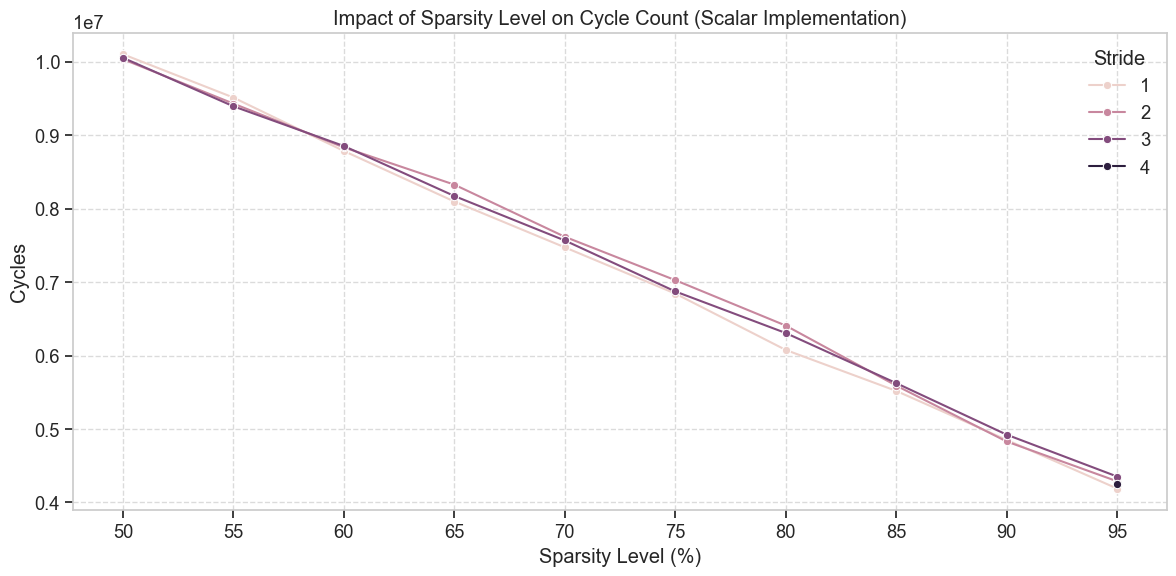

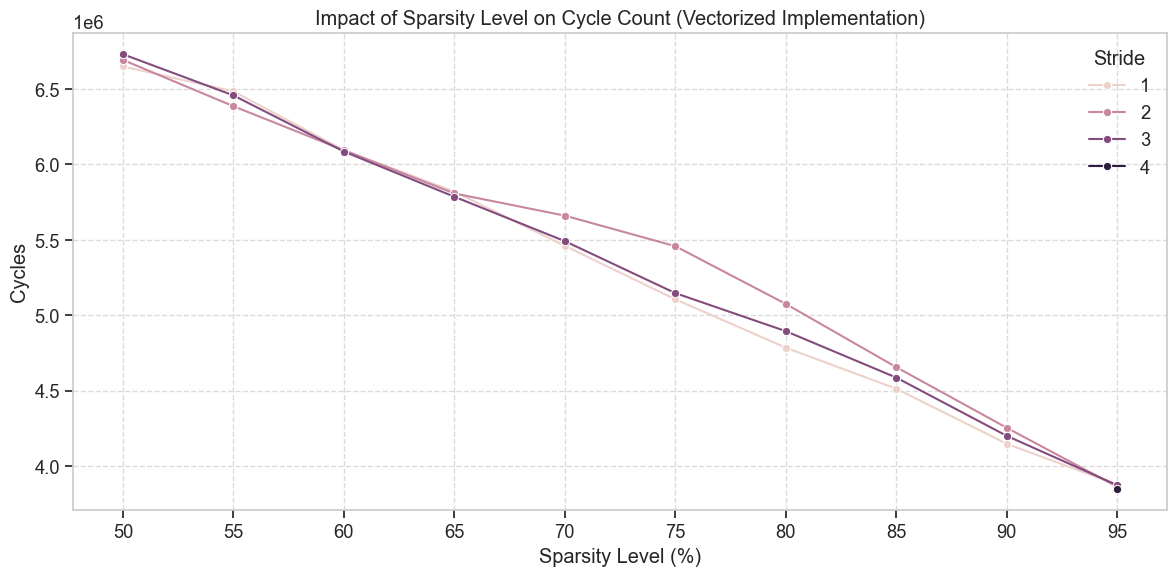

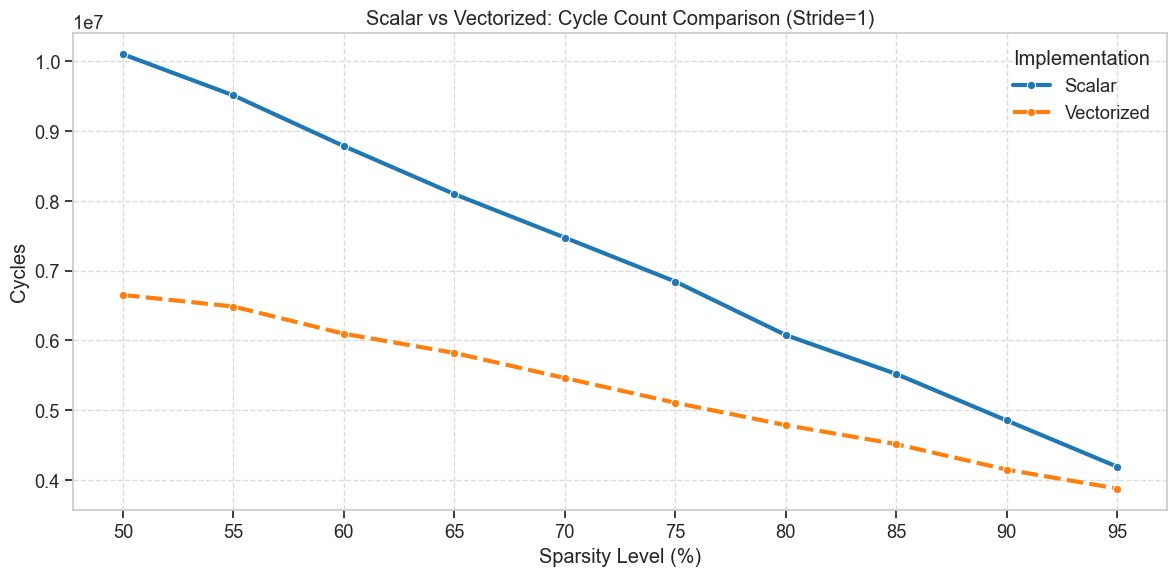

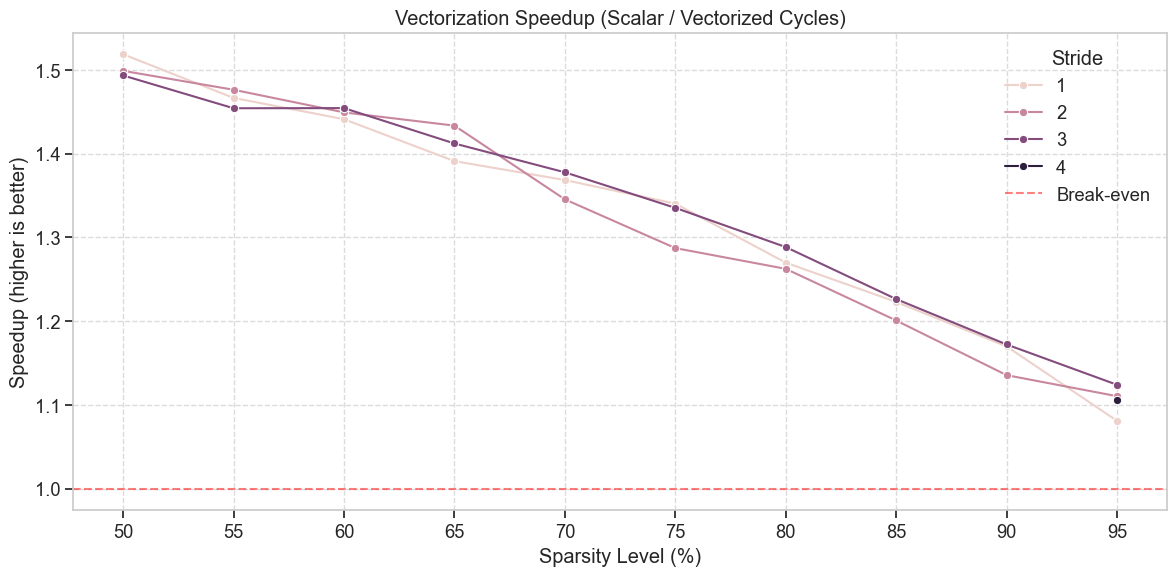

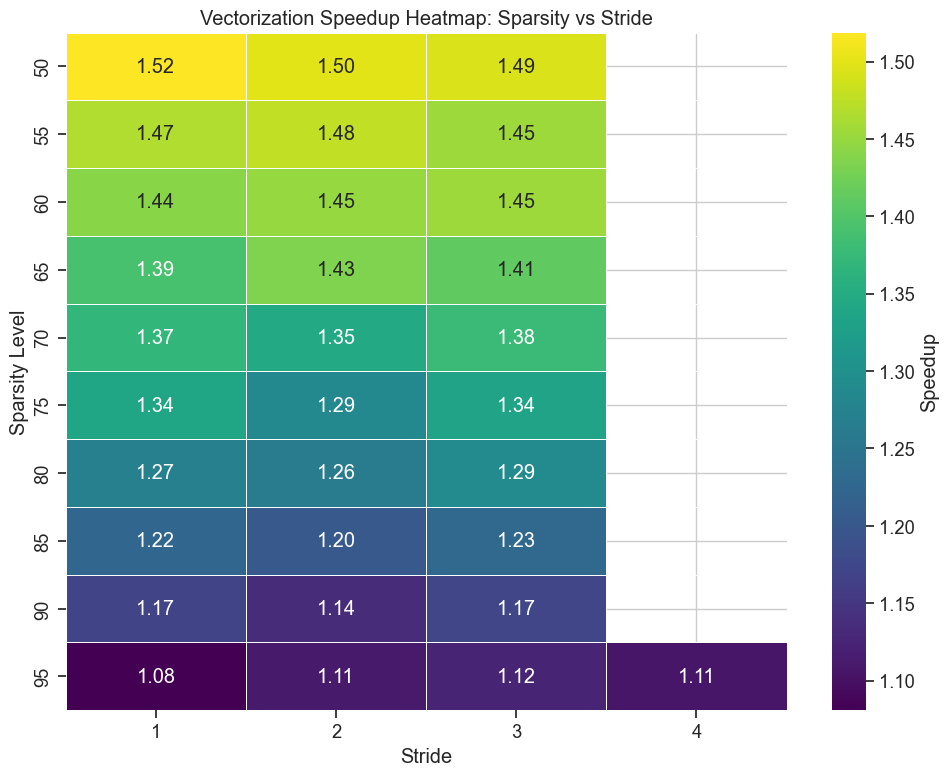

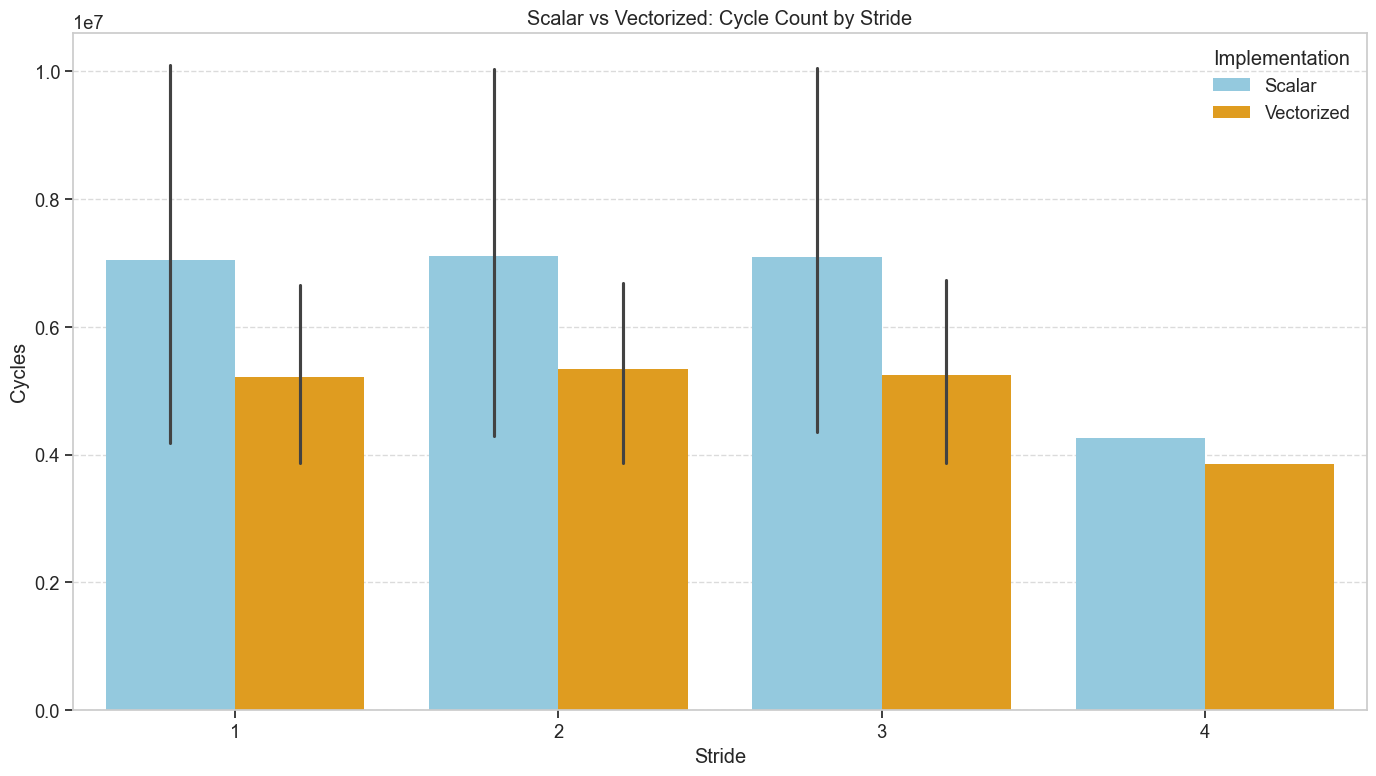

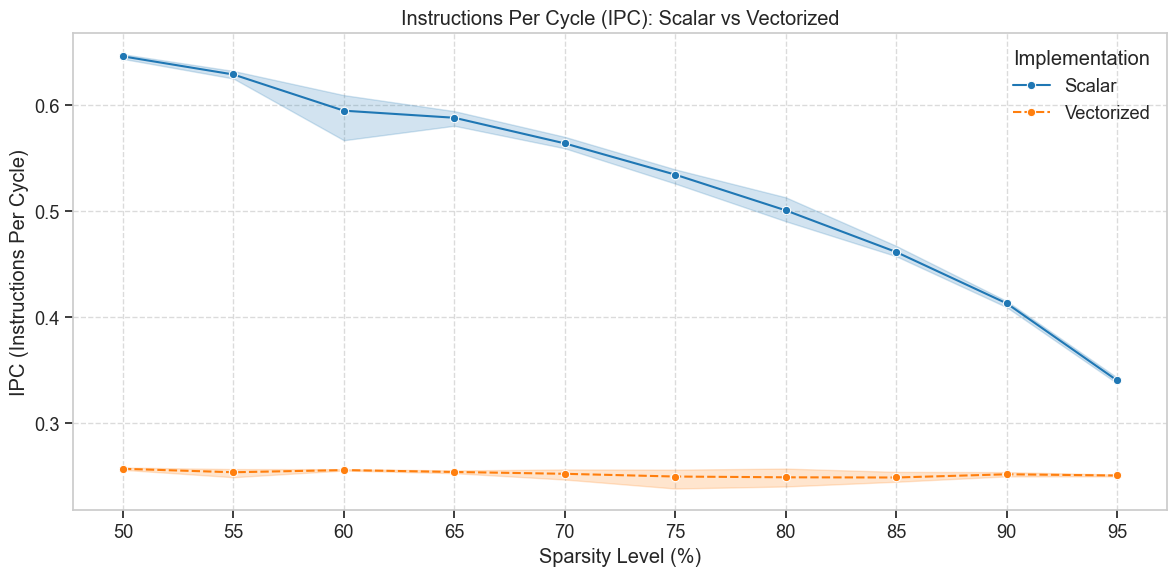

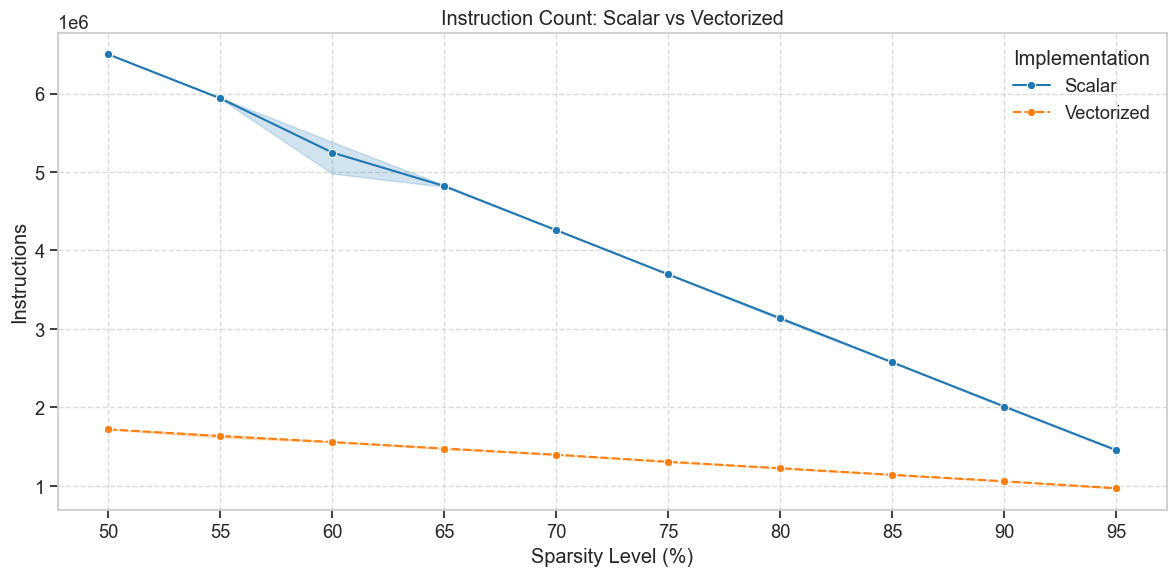

<Figure size 1400x800 with 0 Axes>

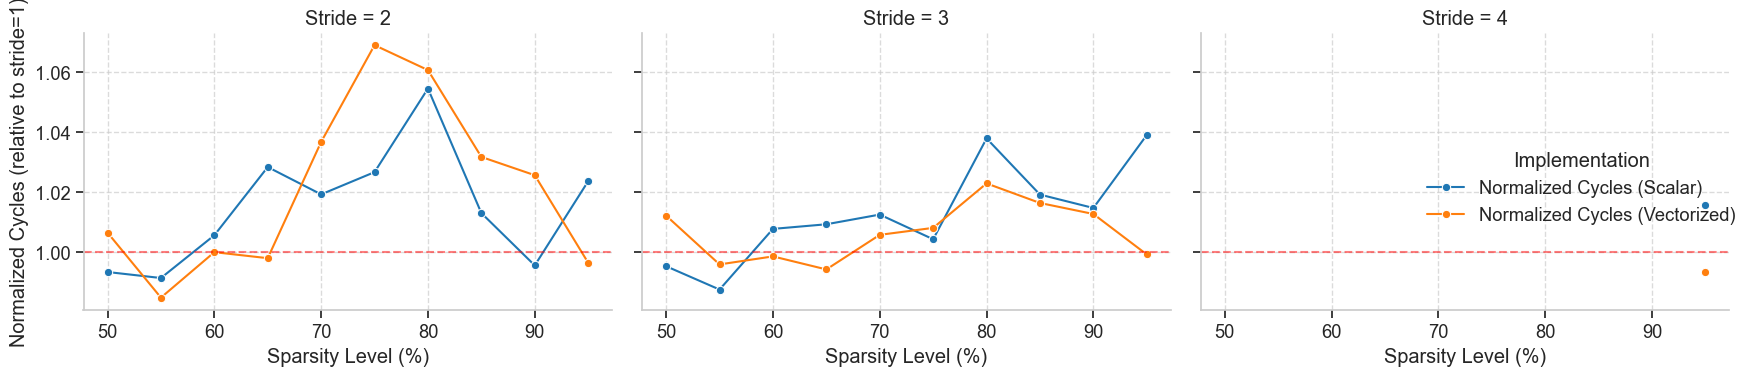

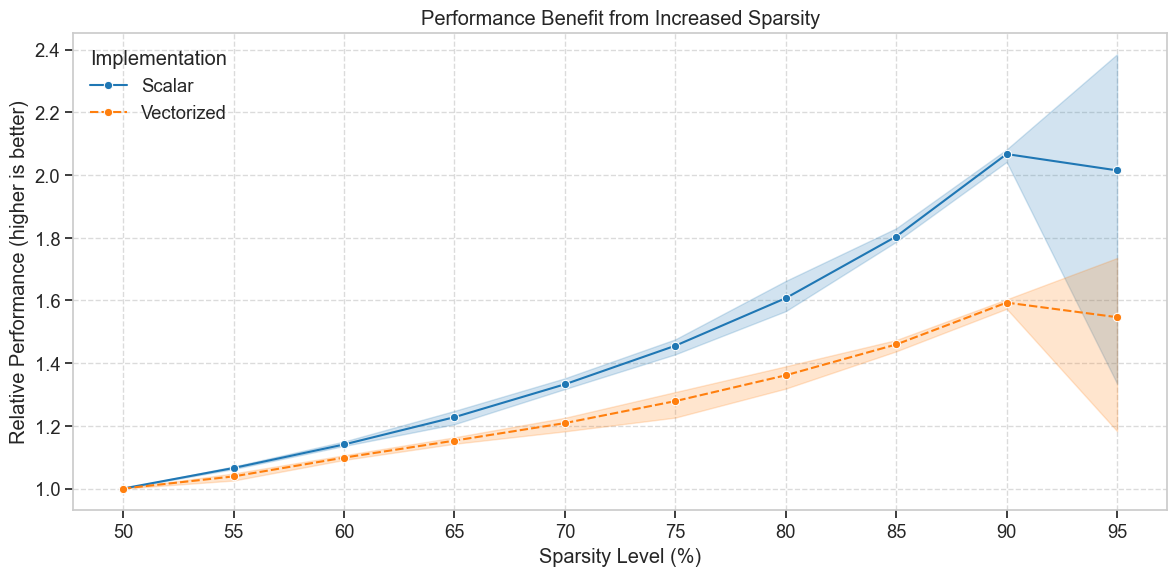


Summary Statistics by Implementation:


Cycles                         Instructions       IPC
                        mean        min         max          mean      mean
Implementation                                                             
Scalar          7.102662e+06  4189452.0  10100090.0  3.881647e+06  0.521060
Vectorized      5.289952e+06  3850411.0   6731025.0  1.335404e+06  0.252139


Summary Statistics by Implementation and Sparsity Level:


Cycles  Instructions       IPC
                                       mean          mean      mean
Implementation Sparsity Level                                      
Scalar         50              1.006171e+07  6.498815e+06  0.645901
               55              9.443442e+06  5.938074e+06  0.628819
               60              8.822356e+06  5.246963e+06  0.594674
               65              8.197311e+06  4.819529e+06  0.588007
               70              7.551263e+06  4.257362e+06  0.563830
               75              6.913618e+06  3.693802e+06  0.534348
               80              6.263118e+06  3.134444e+06  0.500667
               85              5.577832e+06  2.573372e+06  0.461390
               90              4.868082e+06  2.010283e+06  0.412972
               95              4.271577e+06  1.453282e+06  0.340261
Vectorized     50              6.691566e+06  1.719192e+06  0.256923
               55              6.443024e+06  1.634152e+06  0.253649
               60              6.091601e+06  1.557659e+06  0.255706
               65              5.804540e+06  1.473898e+06  0.253920
               70              5.537370e+06  1.396110e+06  0.252188
               75              5.236830e+06  1.305916e+06  0.249613
               80              4.918247e+06  1.223276e+06  0.248889
               85              4.585068e+06  1.140111e+06  0.248706
               90              4.200536e+06  1.057299e+06  0.251723
               95              3.865540e+06  9.686752e+05  0.250592


Conclusions:
1. Average Vectorization Speedup: 1.32x
2. Maximum Vectorization Speedup: 1.52x (at Sparsity=50.0%, Stride=1.0)
3. No vectorization slowdowns detected. Vectorized implementation is faster in all configurations.
4. Sparsity Impact: Scalar implementation benefits 1.30x more from increased sparsity
5. Stride Sensitivity: Vectorized implementation is 1.00x more sensitive to stride changes
6. Best Scalar Configuration: Sparsity=95%, Stride=1, Cycles=4189452
7. Best Vectorized Configuration: Sparsity=95%, Stride=4, Cycles=3850411

Overall Recommendation:
Use the vectorized implementation for better performance (average 1.32x speedup).


In [64]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to process a CSV file into a clean dataframe
def process_csv(filename, implementation_type):
    data_rows = []
    
    # Add header names and types that match your data structure
    column_names = ['index', 'Branch Misses', 'Branches', 'Context Switch', 'CPU Migration', 
                    'Cycles', 'Instructions', 'Page Faults', 'Executable', 'Sparsity Level', 
                    'Stride', 'Implementation']
    
    # Parse the data and clean it up
    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for line in lines[1:]:  # Skip header
            parts = line.strip().split(',')
            row = {}
            
            # Convert to appropriate types
            row['index'] = int(parts[0]) if parts[0] else None
            row['Branch Misses'] = float(parts[1]) if parts[1] else None
            row['Branches'] = float(parts[2]) if parts[2] else None
            row['Context Switch'] = float(parts[3]) if parts[3] else None
            row['CPU Migration'] = float(parts[4]) if parts[4] else None
            row['Cycles'] = float(parts[5]) if parts[5] else None
            row['Instructions'] = float(parts[6]) if parts[6] else None
            row['Page Faults'] = float(parts[7]) if parts[7] else None
            row['Executable'] = parts[8] if parts[8] else None
            row['Sparsity Level'] = int(parts[9]) if parts[9] else None
            row['Stride'] = int(parts[10]) if parts[10] else None
            row['Implementation'] = implementation_type  # Override with the provided implementation type
            
            data_rows.append(row)
    
    df = pd.DataFrame(data_rows)
    return df

# Load and process both CSV files
scalar_df = process_csv('all_results_scalar.csv', 'Scalar')

# For the vectorized version, use the new CSV file
# Replace 'vectorized_data.csv' with your actual filename
vectorized_df = process_csv('all_results_vector.csv', 'Vectorized')

# Combine the datasets
combined_df = pd.concat([scalar_df, vectorized_df], ignore_index=True)

# Function to aggregate metrics for each implementation, sparsity level, and stride
def aggregate_metrics(df):
    metrics_df = pd.DataFrame()
    
    for (impl, sparsity, stride), group in df.groupby(['Implementation', 'Sparsity Level', 'Stride']):
        row = {
            'Implementation': impl,
            'Sparsity Level': sparsity, 
            'Stride': stride
        }
        
        # Extract the metrics for this group
        cycles = group['Cycles'].dropna().mean()
        instructions = group['Instructions'].dropna().mean()
        branch_misses = group['Branch Misses'].dropna().mean()
        branches = group['Branches'].dropna().mean()
        
        row['Cycles'] = cycles
        row['Instructions'] = instructions
        row['Branch Misses'] = branch_misses
        row['Branches'] = branches
        
        # Calculate IPC (Instructions Per Cycle)
        if pd.notna(cycles) and pd.notna(instructions) and cycles > 0:
            row['IPC'] = instructions / cycles
        else:
            row['IPC'] = None
        
        # Add to the metrics dataframe
        metrics_df = pd.concat([metrics_df, pd.DataFrame([row])], ignore_index=True)
    
    # Sort by implementation, sparsity level and stride
    metrics_df = metrics_df.sort_values(['Implementation', 'Sparsity Level', 'Stride'])
    return metrics_df

# Aggregate metrics for the combined dataset
metrics_df = aggregate_metrics(combined_df)

# Display the first few rows to verify the data
print("Aggregated Metrics:")
display(metrics_df.head())

# PART 1: ANALYSIS OF INDIVIDUAL IMPLEMENTATIONS
# First, analyze scalar implementation
scalar_metrics = metrics_df[metrics_df['Implementation'] == 'Scalar']

# Analysis 1: Impact of Sparsity Level on Cycle Count (Scalar)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Cycles', data=scalar_metrics, hue='Stride', marker='o')
plt.title('Impact of Sparsity Level on Cycle Count (Scalar Implementation)')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Cycles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(scalar_metrics['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# Now, analyze vectorized implementation
vectorized_metrics = metrics_df[metrics_df['Implementation'] == 'Vectorized']

# Analysis 2: Impact of Sparsity Level on Cycle Count (Vectorized)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Cycles', data=vectorized_metrics, hue='Stride', marker='o')
plt.title('Impact of Sparsity Level on Cycle Count (Vectorized Implementation)')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Cycles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(vectorized_metrics['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# PART 2: DIRECT COMPARISON BETWEEN SCALAR AND VECTORIZED
# Analysis 3: Compare cycle counts between Scalar and Vectorized (for stride=1)
stride1_comparison = metrics_df[metrics_df['Stride'] == 1]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Cycles', data=stride1_comparison, 
             hue='Implementation', marker='o', style='Implementation', linewidth=3)
plt.title('Scalar vs Vectorized: Cycle Count Comparison (Stride=1)')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Cycles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(stride1_comparison['Sparsity Level'].unique())
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

# Analysis 4: Calculate and plot speedup of vectorized over scalar
# Create a pivot table for easier calculation
pivot_df = metrics_df.pivot_table(index=['Sparsity Level', 'Stride'], 
                                 columns='Implementation', 
                                 values='Cycles').reset_index()

# Calculate speedup: Scalar cycles / Vectorized cycles
pivot_df['Speedup'] = pivot_df['Scalar'] / pivot_df['Vectorized']

plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Speedup', data=pivot_df, hue='Stride', marker='o')
plt.title('Vectorization Speedup (Scalar / Vectorized Cycles)')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Speedup (higher is better)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Break-even')
plt.xticks(pivot_df['Sparsity Level'].unique())
plt.legend(title='Stride')
plt.tight_layout()
plt.show()

# Analysis 5: Heatmap of speedup across sparsity levels and strides
heatmap_data = pivot_df.pivot(index='Sparsity Level', columns='Stride', values='Speedup')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='viridis', 
            linewidths=.5, cbar_kws={'label': 'Speedup'})
plt.title('Vectorization Speedup Heatmap: Sparsity vs Stride')
plt.tight_layout()
plt.show()

# Analysis 6: Bar comparison of cycles for specific sparsity levels
# Select a few representative sparsity levels (e.g., 50%, 75%, and 95%)
sparsity_samples = [50, 75, 95]
sample_data = metrics_df[metrics_df['Sparsity Level'].isin(sparsity_samples)]

plt.figure(figsize=(14, 8))
sns.barplot(x='Stride', y='Cycles', hue='Implementation', 
            data=sample_data, palette=['skyblue', 'orange'])
plt.title('Scalar vs Vectorized: Cycle Count by Stride')
plt.xlabel('Stride')
plt.ylabel('Cycles')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

# Analysis 7: IPC comparison between scalar and vectorized
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='IPC', data=metrics_df, 
             hue='Implementation', style='Implementation', marker='o')
plt.title('Instructions Per Cycle (IPC): Scalar vs Vectorized')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('IPC (Instructions Per Cycle)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(metrics_df['Sparsity Level'].unique())
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

# Analysis 8: Instructions count comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Instructions', data=metrics_df, 
             hue='Implementation', style='Implementation', marker='o')
plt.title('Instruction Count: Scalar vs Vectorized')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Instructions')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(metrics_df['Sparsity Level'].unique())
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

# PART 3: ADVANCED ANALYSIS
# Analysis 9: Performance sensitivity to stride (normalized by stride=1)
def calculate_stride_sensitivity(df, impl):
    impl_df = df[df['Implementation'] == impl]
    pivot = impl_df.pivot(index='Sparsity Level', columns='Stride', values='Cycles')
    normalized = pivot.div(pivot[1], axis=0)
    return normalized.reset_index().melt(id_vars='Sparsity Level', 
                                        var_name='Stride', 
                                        value_name=f'Normalized Cycles ({impl})')

scalar_sensitivity = calculate_stride_sensitivity(metrics_df, 'Scalar')
vectorized_sensitivity = calculate_stride_sensitivity(metrics_df, 'Vectorized')

# Combine the sensitivity dataframes
sensitivity_df = pd.merge(scalar_sensitivity, vectorized_sensitivity, 
                         on=['Sparsity Level', 'Stride'])

# Filter out stride=1 (which is always 1.0)
sensitivity_plot_df = sensitivity_df[sensitivity_df['Stride'] != 1]

# Create a long-format dataframe for easier plotting
sensitivity_long = pd.melt(sensitivity_plot_df, 
                          id_vars=['Sparsity Level', 'Stride'],
                          value_vars=['Normalized Cycles (Scalar)', 'Normalized Cycles (Vectorized)'],
                          var_name='Implementation', value_name='Normalized Cycles')

plt.figure(figsize=(14, 8))
g = sns.FacetGrid(sensitivity_long, col='Stride', hue='Implementation', height=4, aspect=1.2)
g.map(sns.lineplot, 'Sparsity Level', 'Normalized Cycles', marker='o')
g.add_legend(title='Implementation')
g.set_axis_labels('Sparsity Level (%)', 'Normalized Cycles (relative to stride=1)')
g.set_titles('Stride = {col_name}')
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Analysis 10: Which implementation benefits more from increased sparsity?
def calculate_sparsity_benefit(df, impl):
    impl_df = df[df['Implementation'] == impl]
    # Group by stride
    benefit_df = pd.DataFrame()
    
    for stride, group in impl_df.groupby('Stride'):
        # Sort by sparsity level
        group = group.sort_values('Sparsity Level')
        # Calculate benefit: cycles at lowest sparsity / cycles at each sparsity
        lowest_sparsity = group['Sparsity Level'].min()
        lowest_cycles = group[group['Sparsity Level'] == lowest_sparsity]['Cycles'].values[0]
        
        for _, row in group.iterrows():
            benefit_df = pd.concat([benefit_df, pd.DataFrame({
                'Implementation': impl,
                'Stride': stride,
                'Sparsity Level': row['Sparsity Level'],
                'Relative Performance': lowest_cycles / row['Cycles']
            }, index=[0])], ignore_index=True)
    
    return benefit_df

scalar_benefit = calculate_sparsity_benefit(metrics_df, 'Scalar')
vectorized_benefit = calculate_sparsity_benefit(metrics_df, 'Vectorized')
combined_benefit = pd.concat([scalar_benefit, vectorized_benefit], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Sparsity Level', y='Relative Performance', data=combined_benefit, 
             hue='Implementation', style='Implementation', marker='o')
plt.title('Performance Benefit from Increased Sparsity')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Relative Performance (higher is better)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(combined_benefit['Sparsity Level'].unique())
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

# PART 4: SUMMARY STATISTICS AND CONCLUSIONS
# Calculate average speedup across all configurations
average_speedup = pivot_df['Speedup'].mean()
max_speedup = pivot_df['Speedup'].max()
max_speedup_config = pivot_df.loc[pivot_df['Speedup'].idxmax()]

# Find where vectorization hurts performance (if any)
slowdowns = pivot_df[pivot_df['Speedup'] < 1]
has_slowdowns = len(slowdowns) > 0

# Summary statistics by implementation
print("\nSummary Statistics by Implementation:")
display(metrics_df.groupby('Implementation').agg({
    'Cycles': ['mean', 'min', 'max'],
    'Instructions': ['mean'],
    'IPC': ['mean']
}))

# Summary statistics by implementation and sparsity
print("\nSummary Statistics by Implementation and Sparsity Level:")
display(metrics_df.groupby(['Implementation', 'Sparsity Level']).agg({
    'Cycles': ['mean'],
    'Instructions': ['mean'],
    'IPC': ['mean']
}))

# Print conclusions
print("\nConclusions:")
print(f"1. Average Vectorization Speedup: {average_speedup:.2f}x")
print(f"2. Maximum Vectorization Speedup: {max_speedup:.2f}x (at Sparsity={max_speedup_config['Sparsity Level']}%, Stride={max_speedup_config['Stride']})")

if has_slowdowns:
    print("3. Vectorization Slowdowns detected in the following configurations:")
    for _, row in slowdowns.iterrows():
        print(f"   - Sparsity={row['Sparsity Level']}%, Stride={row['Stride']}, Speedup={row['Speedup']:.2f}x")
else:
    print("3. No vectorization slowdowns detected. Vectorized implementation is faster in all configurations.")

# Calculate which implementation benefits more from increased sparsity
scalar_benefit_50_to_95 = scalar_benefit[scalar_benefit['Sparsity Level'] == 95]['Relative Performance'].mean() / \
                         scalar_benefit[scalar_benefit['Sparsity Level'] == 50]['Relative Performance'].mean()
                         
vectorized_benefit_50_to_95 = vectorized_benefit[vectorized_benefit['Sparsity Level'] == 95]['Relative Performance'].mean() / \
                             vectorized_benefit[vectorized_benefit['Sparsity Level'] == 50]['Relative Performance'].mean()

if scalar_benefit_50_to_95 > vectorized_benefit_50_to_95:
    benefit_ratio = scalar_benefit_50_to_95 / vectorized_benefit_50_to_95
    benefit_statement = f"Scalar implementation benefits {benefit_ratio:.2f}x more from increased sparsity"
else:
    benefit_ratio = vectorized_benefit_50_to_95 / scalar_benefit_50_to_95
    benefit_statement = f"Vectorized implementation benefits {benefit_ratio:.2f}x more from increased sparsity"

print(f"4. Sparsity Impact: {benefit_statement}")

# Calculate which implementation is more sensitive to stride changes
scalar_stride_sensitivity = scalar_sensitivity.drop('Sparsity Level', axis=1).mean().std()
vectorized_stride_sensitivity = vectorized_sensitivity.drop('Sparsity Level', axis=1).mean().std()

if scalar_stride_sensitivity > vectorized_stride_sensitivity:
    sensitivity_ratio = scalar_stride_sensitivity / vectorized_stride_sensitivity
    sensitivity_statement = f"Scalar implementation is {sensitivity_ratio:.2f}x more sensitive to stride changes"
else:
    sensitivity_ratio = vectorized_stride_sensitivity / scalar_stride_sensitivity
    sensitivity_statement = f"Vectorized implementation is {sensitivity_ratio:.2f}x more sensitive to stride changes"

print(f"5. Stride Sensitivity: {sensitivity_statement}")

# Best configuration for each implementation
best_scalar = scalar_metrics.loc[scalar_metrics['Cycles'].idxmin()]
best_vectorized = vectorized_metrics.loc[vectorized_metrics['Cycles'].idxmin()]

print(f"6. Best Scalar Configuration: Sparsity={best_scalar['Sparsity Level']}%, Stride={best_scalar['Stride']}, Cycles={best_scalar['Cycles']:.0f}")
print(f"7. Best Vectorized Configuration: Sparsity={best_vectorized['Sparsity Level']}%, Stride={best_vectorized['Stride']}, Cycles={best_vectorized['Cycles']:.0f}")

# Overall recommendation
print("\nOverall Recommendation:")
if average_speedup > 1:
    print(f"Use the vectorized implementation for better performance (average {average_speedup:.2f}x speedup).")
    
    if has_slowdowns:
        print("However, be cautious with the following configurations where the scalar implementation is faster:")
        for _, row in slowdowns.iterrows():
            print(f"- Sparsity={row['Sparsity Level']}%, Stride={row['Stride']}")
else:
    print("The scalar implementation generally performs better than the vectorized implementation.")